# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Georgia;text-align:center;display:fill;border-radius:30px;background-color:#404040;overflow:hidden"><b>Project<br><br>DrapeAura 2023 E-Commerce Analysis: Product Segmentation</b></div>

<a id="Table"></a>
# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Georgia;text-align:center;display:fill;border-radius:30px;background-color:#404040;overflow:hidden"><b>Table of Contents</b></div>

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">
    
- [Introduction](#intro)
- [Objectives](#Objective)
- [Import Libraries](#library)
- [Gathering And Assessing Data](#Gather)
- [Exploratory Data Analysis (EDA)](#EDA)
- [Applying the NMF algorithm to Merged Categories](#NMF)
  - [Scaling Strategy Before NMF – Merged Product Categories](#Scale)
  - [Determining the Optimal Number of Components – Merged Product Categories](#Deter)
- [Product Category Segmentation by Gender (Male/Female)](#Gender)
  - [1. Segmentation by Male](#Male)
  - [2. Segmentation by Female](#Female)
- [Conclusions & Insights](#Concl)
- [View On Tableau](#Tableau)


<br>

<a id="intro"></a>
# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Georgia;text-align:center;display:fill;border-radius:30px;background-color:#404040;overflow:hidden"><b>Introduction</b></div>


<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">
    
This project explores advanced segmentation of e-commerce customers based on their aggregated product purchases, with the goal of improving personalization, marketing effectiveness, and customer engagement.

While traditional analyses often rely on demographic or basic transactional summaries, this initiative adopts a behavior-first approach—where segmentation is derived from what customers actually buy, not just who they are.

To accommodate the complexity of customer behaviors and product diversity (over 13,000 products across 26 categories), we focus on reducing dimensionality and capturing latent shopping patterns. This is achieved by constructing multiple purchase matrices (e.g., Customer × Category, segmented by gender), and applying various unsupervised learning techniques to uncover meaningful clusters.

> **Note**: At this stage, we have not yet committed to a final clustering algorithm. Instead, we evaluate multiple paths (e.g., dimensionality reduction + clustering, direct matrix factorization) to determine the most suitable approach based on data sparsity, interpretability, and business alignment.


<br>

<br>

<a id="Objective"></a>
# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Georgia;text-align:center;display:fill;border-radius:30px;background-color:#404040;overflow:hidden"><b>Objectives</b></div>

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">
    
## 🎯 The core objectives of this project are:

### 1. Develop a Behavior-Based Segmentation Approach
- Construct customer × category purchase matrices (including merged and gender-specific versions).
- Address data sparsity using appropriate preprocessing (e.g., robust scaling and zero-preservation).

### 2. Evaluate Suitable Segmentation Techniques
- Explore different segmentation paths:
  - Direct clustering (e.g., K-Means)
  - Matrix factorization (e.g., NMF) to uncover latent purchasing behaviors
- Compare methods using silhouette scores, reconstruction errors, and interpretability.

### 3. Interpret and Label Segments
- Identify top product categories for each segment.
- Analyze demographic traits (age, gender, region) to contextualize each group.
- Assign meaningful labels to support downstream applications (e.g., “Comfort-Focused Shoppers”, “Seasonal Buyers”).

### 4. Support Marketing and Product Strategy
- Translate segments into actionable business insights:
  - Personalized promotions
  - Gender-specific bundling strategies
  - Regional campaign targeting

---

These objectives ensure that the segmentation framework is both statistically valid and directly aligned with business goals, paving the way for smarter recommendations and more relevant customer engagement.


<br>

<a id="library"></a>
# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Georgia;text-align:center;display:fill;border-radius:30px;background-color:#404040;overflow:hidden"><b>Import Libraries</b></div>

- **Basic Libraries: Importing Essential Libraries for Data Processing and Visualization.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
%matplotlib inline
sns.set_style("white")
pd.options.display.max_columns = 30

<br>

- **Machine Learning Libraries: Importing libraries for segmenting data.**

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
from sklearn.decomposition import NMF

<a id="Gather"></a>
# <div style="padding:20px;color:white;margin:0;font-size:25px;font-family:Georgia;text-align:center;display:fill;border-radius:30px;background-color:#404040;overflow:hidden"><b>Gathering And Assessing Data</b></div>

- **Loading the `us_product_sales_23` dataset for 2023.**

In [3]:
df = pd.read_csv("us_product_sales_23.csv")

df.head()

,order_item_id,invoice_no,product_id,product_description,category,brand,department,transaction_date,cost,shipping_cost_1000_mile,unit_price,quantity,sales,customer_id,age,gender,postal_code,city,state,state_ab,region,customer_latitude,customer_longitude,state_latitude,state_longitude
0,142771,98298,13928,Low Profile Dyed Cotton Twill Cap - Putty W39S55D,Accessories,MG,Women,2023-11-19 09:52:00+00:00,2.34,0.19,5.95,4,23.80,78444,39,F,38655,Oxford,Mississippi,MS,South,34.329453,-89.468527,32.741646,-89.678696
1,142772,98298,5803,LOCOMO Women Patriot Patriotic Great Britain B...,Leggings,LOCOMO Leggings,Women,2023-11-19 09:52:00+00:00,8.74,0.81,14.99,3,44.97,78444,39,F,38655,Oxford,Mississippi,MS,South,34.329453,-89.468527,32.741646,-89.678696
2,142774,98298,10182,Floral Flannel Pajamas - Misses Sizes,Sleep & Lounge,Carol Wright Gifts,Women,2023-11-19 09:52:00+00:00,10.08,0.82,16.99,2,33.98,78444,39,F,38655,Oxford,Mississippi,MS,South,34.329453,-89.468527,32.741646,-89.678696
3,142776,98299,12882,Speedo Women's Color Block Zip Front Endurance...,Swim,Speedo,Women,2023-11-30 09:52:00+00:00,35.04,3.26,79.99,5,399.95,78444,39,F,38655,Oxford,Mississippi,MS,South,34.329453,-89.468527,32.741646,-89.678696
4,142775,98299,15918,Glamorise Women's Soft Shoulders Minimizer Bra...,Plus,Glamorise,Women,2023-11-30 09:52:00+00:00,22.81,1.97,45.99,4,183.96,78444,39,F,38655,Oxford,Mississippi,MS,South,34.329453,-89.468527,32.741646,-89.678696


<br>

- **Check the basic information of the data frame.**

In [4]:
df.shape

(18819, 25)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18819 entries, 0 to 18818
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_item_id            18819 non-null  int64  
 1   invoice_no               18819 non-null  int64  
 2   product_id               18819 non-null  int64  
 3   product_description      18819 non-null  object 
 4   category                 18819 non-null  object 
 5   brand                    18819 non-null  object 
 6   department               18819 non-null  object 
 7   transaction_date         18819 non-null  object 
 8   cost                     18819 non-null  float64
 9   shipping_cost_1000_mile  18819 non-null  float64
 10  unit_price               18819 non-null  float64
 11  quantity                 18819 non-null  int64  
 12  sales                    18819 non-null  float64
 13  customer_id              18819 non-null  int64  
 14  age                   

In [6]:
df.duplicated().sum()

0

&#9865; **There are no Null values, duplicate columns or rows, and the column data types are compatible.**<br><br>

<a id="EDA"></a>
# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Georgia;text-align:center;display:fill;border-radius:30px;background-color:#404040;overflow:hidden"><b>Exploratory Data Analysis (EDA)</b></div>

- **Check unique numbers for each category and product separately.**

In [7]:
df[['product_id', 'category']].nunique()

product_id    13756
category         26
dtype: int64

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">
    
### 📊 Product Distribution Overview: 13,756 Products Across 26 Categories

The dataset contains **13,756 unique products** distributed across **26 distinct categories**. While this richness in product diversity provides analytical depth, it introduces challenges related to **dimensionality and sparsity**.

---

### ⚠️ Key Challenges

#### 🚧 High Dimensionality & Sparsity
- Building a **Customer × Product** matrix would involve **13,756 columns**, making it **extremely sparse** (most entries are zeros).
- This leads to:
  - **Inefficient modeling** (e.g., slower convergence, overfitting).
  - **Difficulty applying algorithms like K-Means** (due to distorted distance calculations).
  - A heightened risk of the **curse of dimensionality**, where patterns become difficult to detect due to excessive feature space.

---

### 🔍 Practical Insights & Recommendations

#### ✅ Check Distribution
- **Review the product count per category** to identify:
  - Categories with too few products.
  - Random or isolated purchases that add noise.
  - Overlapping or ambiguous category names.

#### ✅ Merge or Rename Strategically
- **Merge small or similar categories** to reduce clutter.
- **Rename vague categories** to improve consistency and interpretability.

#### ✅ Start with Category-Level Analysis
- Begin with a **Customer × Category** matrix:
  - Reduces dimensionality dramatically (26 columns vs. 13,756).
  - Maintains useful patterns without excessive sparsity.
  - Serves as a stable foundation for modeling (NMF, clustering, etc.).

---

### 🧠 Final Insight

> **13,756 products across 26 categories** is a strong argument for **dimension reduction first by category**, then diving deeper within important categories if needed.

This two-level strategy (category first, then product) ensures:
- Lower sparsity.
- Higher interpretability.
- Better model performance.
- Alignment with real business segmentation and product hierarchies.

**review the 4 additional custom/merged categories** for data integrity and business relevance.

<br>

- **Check the distribution of products across categories.**

In [8]:
def bar_chart(df, bar_color, bar_title, bar_xlabel, bar_ylabel, ylim_max):
    """Create a customizable bar chart with value annotations.
    
    Args:
        df: Input DataFrame with data to plot
        bar_color: Color for bars (name or hex code)
        bar_title: Chart title string
        bar_xlabel: X-axis label string
        bar_ylabel: Y-axis label string
        ylim_max: Maximum y-axis value
    """
    # Create base bar plot
    ax = df.plot(
        kind="bar",
        color=bar_color,
        grid=True,
        figsize=(10, 5),
        edgecolor='black',  # Add border to bars
        alpha=0.8          # Slight transparency
    )
    
    # Add formatted value labels
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():,.1f}',  # Format with 1 decimal and commas
            (p.get_x() + p.get_width() / 2, p.get_height() + 0.05*ylim_max),
            ha='center',
            va='bottom',
            rotation=90,
            fontsize=10
        )
    
    # Style the plot
    ax.set_title(bar_title, fontsize=16, pad=20)
    ax.set_xlabel(bar_xlabel, fontsize=12)
    ax.set_ylabel(bar_ylabel, fontsize=12)
    ax.set_ylim(0, ylim_max);

In [9]:
num_prod_by_category = df.groupby("category")["product_id"].nunique().sort_values(ascending=False)

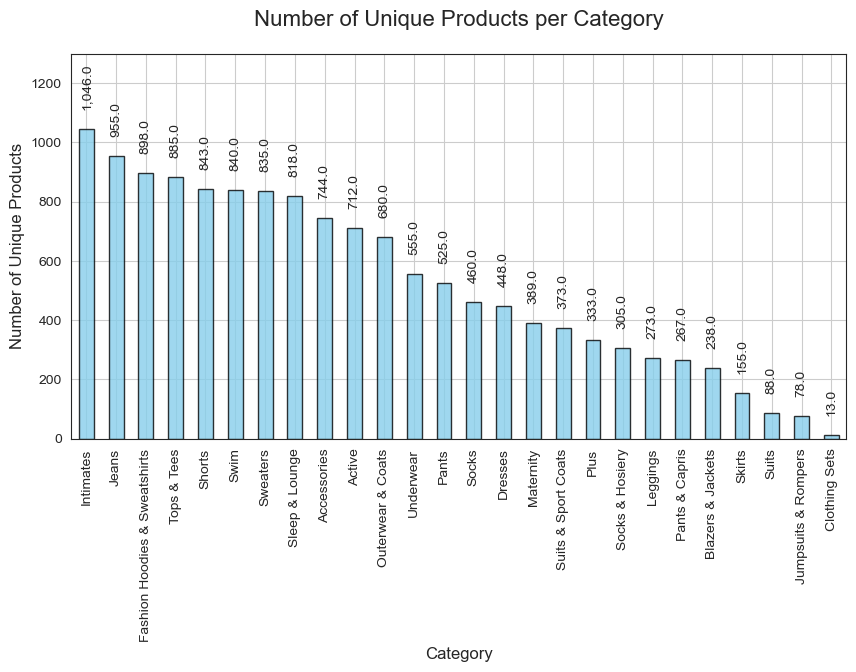

In [10]:
bar_chart(
    df=num_prod_by_category, 
    bar_color="skyblue", 
    bar_title="Number of Unique Products per Category", 
    bar_xlabel="Category", 
    bar_ylabel="Number of Unique Products",
    ylim_max=1300)

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">
    
### 📦 Unique Product Counts per Category – Overview

An analysis of the number of unique products across categories reveals critical imbalances that can impact model reliability and interpretability.

---

### 🚨 Extremely Rare Categories (< 100 Products)

These categories contain **fewer than 100 unique products**, making them **statistically fragile** and prone to overfitting in modeling:

| Category              | Unique Product Count |
|-----------------------|----------------------|
| Clothing Sets         | 13                   |
| Jumpsuits & Rompers   | 78                   |
| Suits                 | 88                   |

#### ⚠️ Issues with Rare Categories:
- **Model Instability**: Algorithms may assign disproportionate weight to these categories due to their low frequency.
- **Interpretability Challenges**: Insufficient product diversity leads to unreliable pattern extraction and weak segment characterization.

---

### 🛠 Recommended Remediation Actions

To address these risks and enhance analytical robustness, the following category consolidations are advised:

#### ✅ Merge `Suits` → `Suits & Sport Coats`  
- **Why**: There’s an existing, more populated category (`Suits & Sport Coats`, ~300+ products).  
- **Result**: Unifies formalwear under a broader and more reliable category (`Suits & Blazers`), improving model clarity.

#### ✅ Merge `Jumpsuits & Rompers` + `Clothing Sets` → `One-Piece`  
- **Why**: These are all one-piece garments with overlapping styles and use cases.  
- **Result**: Creates a new `One-Piece` category that has a more meaningful size and marketing relevance.

---

### ✅ Benefits of Category Consolidation

- **Increased Stability**: Larger category sizes reduce variance and increase pattern reliability.
- **Improved Interpretability**: Segments become easier to understand and act upon.
- **Enhanced Modeling**: Reduces sparsity and improves factor extraction in dimensionality reduction algorithms (e.g., NMF).

> Consolidating rare categories ensures your analytical framework remains statistically sound and marketing insights stay actionable.

<br>

- **Merge “Suits” with “Suits & Sport Coats” and “Jumpsuits & Rompers”, “Clothing Sets” into the “One-Pieces” category.**

In [11]:
# Category consolidation mapping (modify as needed)
category_mapping = {
    'Suits': 'Suits & Sport Coats',          # Merge suit categories
    'Suits & Sport Coats': 'Suits & Sport Coats',
    'Jumpsuits & Rompers': 'One-Pieces',     # Group similar items
    'Clothing Sets': 'One-Pieces'
}

# Apply mapping and keep original if no mapping exists
df['category_merged'] = df['category'].map(category_mapping).fillna(df['category'])

In [12]:
df['category_merged'].unique()

array(['Accessories', 'Leggings', 'Sleep & Lounge', 'Swim', 'Plus',
       'One-Pieces', 'Active', 'Skirts', 'Blazers & Jackets', 'Shorts',
       'Outerwear & Coats', 'Fashion Hoodies & Sweatshirts', 'Underwear',
       'Pants', 'Tops & Tees', 'Socks', 'Dresses', 'Intimates',
       'Suits & Sport Coats', 'Jeans', 'Sweaters', 'Socks & Hosiery',
       'Maternity', 'Pants & Capris'], dtype=object)

<br>

- **Double-check the distribution of products across new categories after merging.**

In [13]:
num_prod_by_category = df.groupby("category_merged")["product_id"].nunique().sort_values(ascending=False)

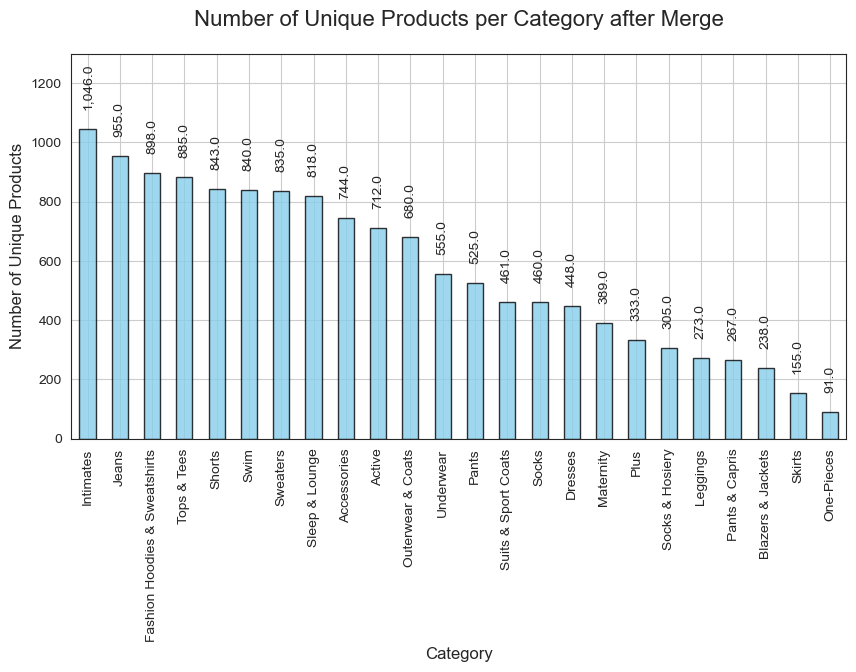

In [14]:
bar_chart(
    df=num_prod_by_category, 
    bar_color="skyblue", 
    bar_title="Number of Unique Products per Category after Merge", 
    bar_xlabel="Category", 
    bar_ylabel="Number of Unique Products",
    ylim_max=1300)

<br>

- **Check the distribution of products for each category by gender.**

In [15]:
def side_by_side_bar(
    df_matrix,
    mode='category',  # 'category', 'stats'
    bar1=None,
    bar2=None,
    bar1_label=None,
    bar2_label=None,
    ylim_max=None,
    use_percentage=False,
    annotation_format='.1f',
    colors=('gray', 'orange'),
    title=None,
    xlabel=None,
    ylabel=None,
    figsize=(15, 8),
    xlabel_rotation=90,
    annotation_rotation=90,
    fontsize=14,
    annotation_fontsize=12
):
    """
    Unified function to create side-by-side bar charts with 2 modes:
    1. 'category': Compare two specific rows from DataFrame with percentage formatting optional
    2. 'stats': Show mean and standard deviation

    
    Parameters:
    - df_matrix: Input DataFrame
    - mode: Operation mode ('category', 'stats')
    - bar1/bar2: Row names for category mode
    - bar1_label/bar2_label: Custom legend labels
    - ylim_max: Y-axis maximum limit
    - use_percentage: Format y-axis as percentages
    - annotation_format: Format string for bar labels
    - colors: Tuple of two colors for the bars
    - title/xlabel/ylabel: Chart titles
    - figsize: Figure dimensions
    - xlabel_rotation: X-axis label rotation
    - annotation_rotation = Bar annotation rotation
    - fontsize: Base font size
    - annotation_fontsize: Bar label font size
    """
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Data preparation based on mode
    if mode == 'category':
        if bar1 is None or bar2 is None:
            raise ValueError("Must specify bar1 and bar2 in category mode")
        if bar1 not in df_matrix.index or bar2 not in df_matrix.index:
            raise ValueError("Specified rows not found in DataFrame")
        
        data1 = df_matrix.loc[bar1].values
        data2 = df_matrix.loc[bar2].values
        labels = [bar1_label or bar1, bar2_label or bar2]
        
        if use_percentage and annotation_format == '.1f':
            annotation_format = '.0%'
        
    elif mode == 'stats':
        data1 = df_matrix.mean().values
        data2 = df_matrix.std().values
        labels = ['Mean', 'Standard Deviation']
        
    else:
        raise ValueError("Invalid mode. Choose: 'category', 'gender'")
    
    # Setup positions and names
    x_names = df_matrix.columns.tolist()
    x_ix = np.arange(len(x_names))
    width = 0.4  # Bar width
    
    # Plot bars
    bars1 = ax.bar(x_ix - width/2, data1, color=colors[0], label=labels[0], width=width)
    bars2 = ax.bar(x_ix + width/2, data2, color=colors[1], label=labels[1], width=width)
    
    # Add value annotations
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                f'{height:{annotation_format}}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center',
                va='bottom',
                fontsize=annotation_fontsize,
                rotation=annotation_rotation
            )
    
    # Axis formatting
    ax.set_xticks(x_ix)
    ax.set_xticklabels(x_names, fontsize=fontsize, rotation=xlabel_rotation)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.legend(fontsize=fontsize)
    
    if ylim_max is not None:
        ax.set_ylim(0, ylim_max)
        
    if use_percentage:
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
        if ylim_max is None:
            ax.set_ylim(0, 1.1)
            
    # Add titles if specified
    if title:
        ax.set_title(title, fontsize=fontsize+6, pad=20)
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=fontsize+2)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=fontsize+2);

In [16]:
depart_cat_matrix = df.pivot_table(index="department", 
                                 columns="category", 
                                 values="product_id", 
                                 aggfunc="nunique",
                                 fill_value= 0
                                 )

depart_cat_matrix

category,Accessories,Active,Blazers & Jackets,Clothing Sets,Dresses,Fashion Hoodies & Sweatshirts,Intimates,Jeans,Jumpsuits & Rompers,Leggings,Maternity,Outerwear & Coats,Pants,Pants & Capris,Plus,Shorts,Skirts,Sleep & Lounge,Socks,Socks & Hosiery,Suits,Suits & Sport Coats,Sweaters,Swim,Tops & Tees,Underwear
department,,,,,,,,,,,,,,,,,,,,,,,,,,
Men,422,392,0,0,0,486,0,587,0,0,0,408,525,0,0,460,0,464,460,0,0,373,510,461,550,555
Women,322,320,238,13,448,412,1046,368,78,273,389,272,0,267,333,383,155,354,0,305,88,0,325,379,335,0


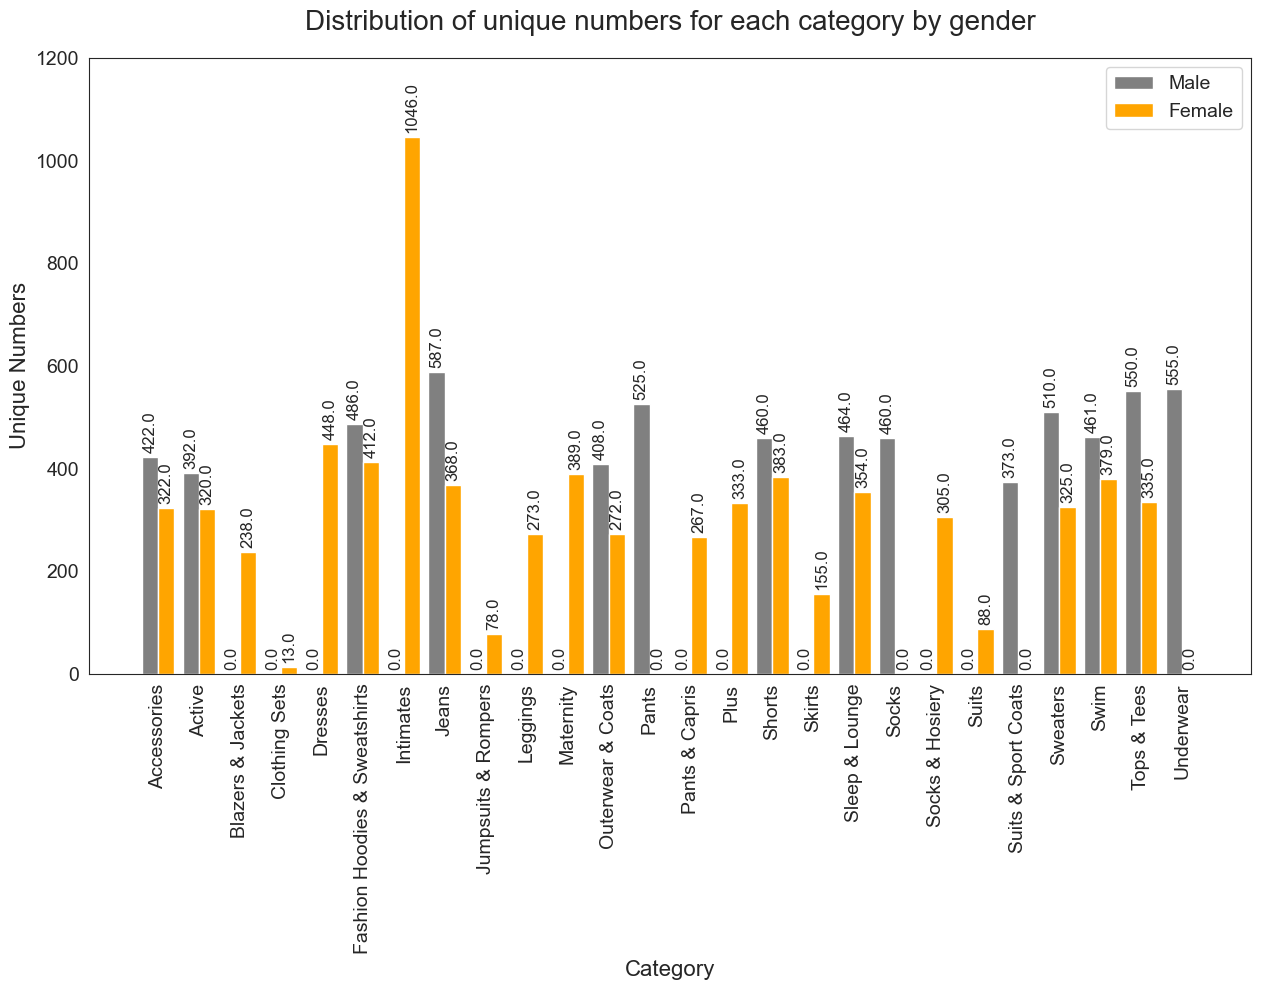

In [17]:
side_by_side_bar(
    depart_cat_matrix, bar1='Men', bar2='Women',
    bar1_label='Male', bar2_label='Female',
    ylim_max=1200, title='Distribution of unique numbers for each category by gender',
    xlabel='Category', ylabel='Unique Numbers',
    figsize=(15, 8), fontsize=14, annotation_fontsize=12
)

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">
    
### 📊 Gender-Based Distribution of Unique Product Categories

This section outlines key findings from the distribution of product categories across genders. It highlights patterns of exclusivity, balance, and potential modeling strategies.

---

### 👗🧥 Gender-Specific Dominance

#### ✅ Categories Almost Exclusive to Women:
These categories appear **primarily or exclusively** in the women's product section, reflecting strong gender targeting:

- `Intimates`
- `Maternity`
- `Skirts`
- `Hosiery`

#### ✅ Categories Primarily in Men’s Section:
These are more prevalent in the men’s catalog:

- `Suits & Sport Coats`
- `Underwear`

Such categories are **excellent candidates for gender-specific recommendation systems** or targeted promotions.

---

### ⚖️ Balanced Categories Across Genders

The following categories are **relatively balanced**, appearing in both men’s and women’s sections in comparable counts:

| Category       | Female Count | Male Count |
|----------------|--------------|------------|
| Accessories    | 422          | 322        |
| Active         | 392          | 320        |
| Swim           | 461          | 379        |

These categories are ideal for:
- **Hybrid recommendation models**
- **Cross-gender behavioral comparisons**
- **Integrated promotional strategies**

---

### 🚫 Categories for Exclusion or Special Handling

Some categories are either rare or **duplicated under slightly different names** across genders:

- `Socks` (Men's only, 460 products)
- `Socks & Hosiery` (Women's only, 305 products)

#### 🔧 Suggested Actions:
- **Combine**: Merge `Socks` and `Socks & Hosiery` for consistency in a full matrix.
- **Separate Treatment**: Keep them distinct when using **gender-specific segmentation**, as we did in our dual-matrix approach.

---

### 🧠 Modeling Recommendations

| Use Case                                   | Recommendation                            | Why?                                                   |
|--------------------------------------------|--------------------------------------------|--------------------------------------------------------|
| Gender-specific modeling                   | Use original categories                    | Preserves fine-grained behavior differences            |
| Hybrid/cross-gender modeling               | Focus on balanced/shared categories        | Ensures signal consistency across male/female datasets |
| Sparse/rare category handling              | Combine similar low-volume categories      | Reduces noise and sparsity                             |

> By analyzing the original category distribution by gender, you ensure that both model precision and marketing strategies are rooted in product relevance and customer behavior.

<br>

- **Merge similar product categories for better analysis.**

In [18]:
category_mapping = {
    # Footwear grouping
    'Socks': 'Socks & Hosiery',
    'Socks & Hosiery': 'Socks & Hosiery',
    
    # Bottom wear grouping
    'Jeans': 'Bottoms',
    'Pants': 'Bottoms', 
    'Skirts': 'Bottoms',
    'Shorts': 'Bottoms',
    
    # One-piece outfits
    'One-Pieces': 'One-Pieces',
    'Dresses': 'One-Pieces',
    'Rompers': 'One-Pieces',
    
    # Intimates grouping
    'Intimates': 'Underwear & Intimates',
    'Underwear': 'Underwear & Intimates',
    
    # Formal wear grouping
    'Suits & Sport Coats': 'Formal Wear',
    'Blazers': 'Formal Wear',
}

# Apply category merging while preserving unmapped categories
df['category_merged'] = df['category_merged'].map(category_mapping).fillna(df['category'])


In [19]:
df['category_merged'].unique()

array(['Accessories', 'Leggings', 'Sleep & Lounge', 'Swim', 'Plus',
       'One-Pieces', 'Active', 'Bottoms', 'Blazers & Jackets',
       'Outerwear & Coats', 'Fashion Hoodies & Sweatshirts',
       'Underwear & Intimates', 'Tops & Tees', 'Socks & Hosiery',
       'Formal Wear', 'Sweaters', 'Maternity', 'Pants & Capris'],
      dtype=object)

<br>

- **One last check that the products are distributed across the new categories after the merger.**

In [20]:
num_prod_by_category = df.groupby("category_merged")["product_id"].nunique().sort_values(ascending=False)

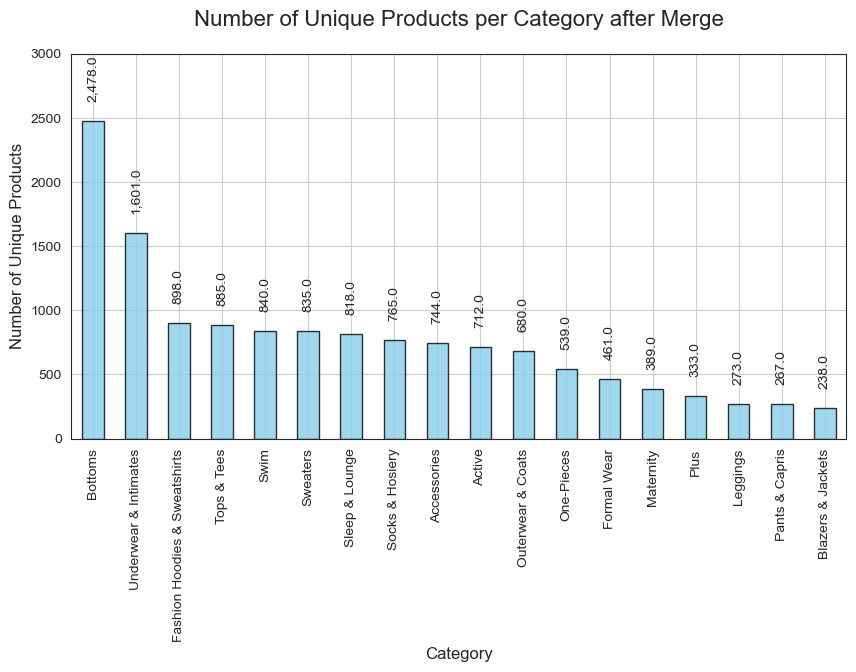

In [21]:
bar_chart(
    df=num_prod_by_category, 
    bar_color="skyblue", 
    bar_title="Number of Unique Products per Category after Merge", 
    bar_xlabel="Category", 
    bar_ylabel="Number of Unique Products",
    ylim_max=3000)

<br>

- **Double-check the distribution of products for each category by gender after merging.**

In [22]:
depart_cat_matrix = df.pivot_table(index="department", 
                                 columns="category_merged", 
                                 values="product_id", 
                                 aggfunc="nunique",
                                 fill_value= 0
                                 )

depart_cat_matrix

category_merged,Accessories,Active,Blazers & Jackets,Bottoms,Fashion Hoodies & Sweatshirts,Formal Wear,Leggings,Maternity,One-Pieces,Outerwear & Coats,Pants & Capris,Plus,Sleep & Lounge,Socks & Hosiery,Sweaters,Swim,Tops & Tees,Underwear & Intimates
department,,,,,,,,,,,,,,,,,,
Men,422,392,0,1572,486,373,0,0,0,408,0,0,464,460,510,461,550,555
Women,322,320,238,906,412,88,273,389,539,272,267,333,354,305,325,379,335,1046


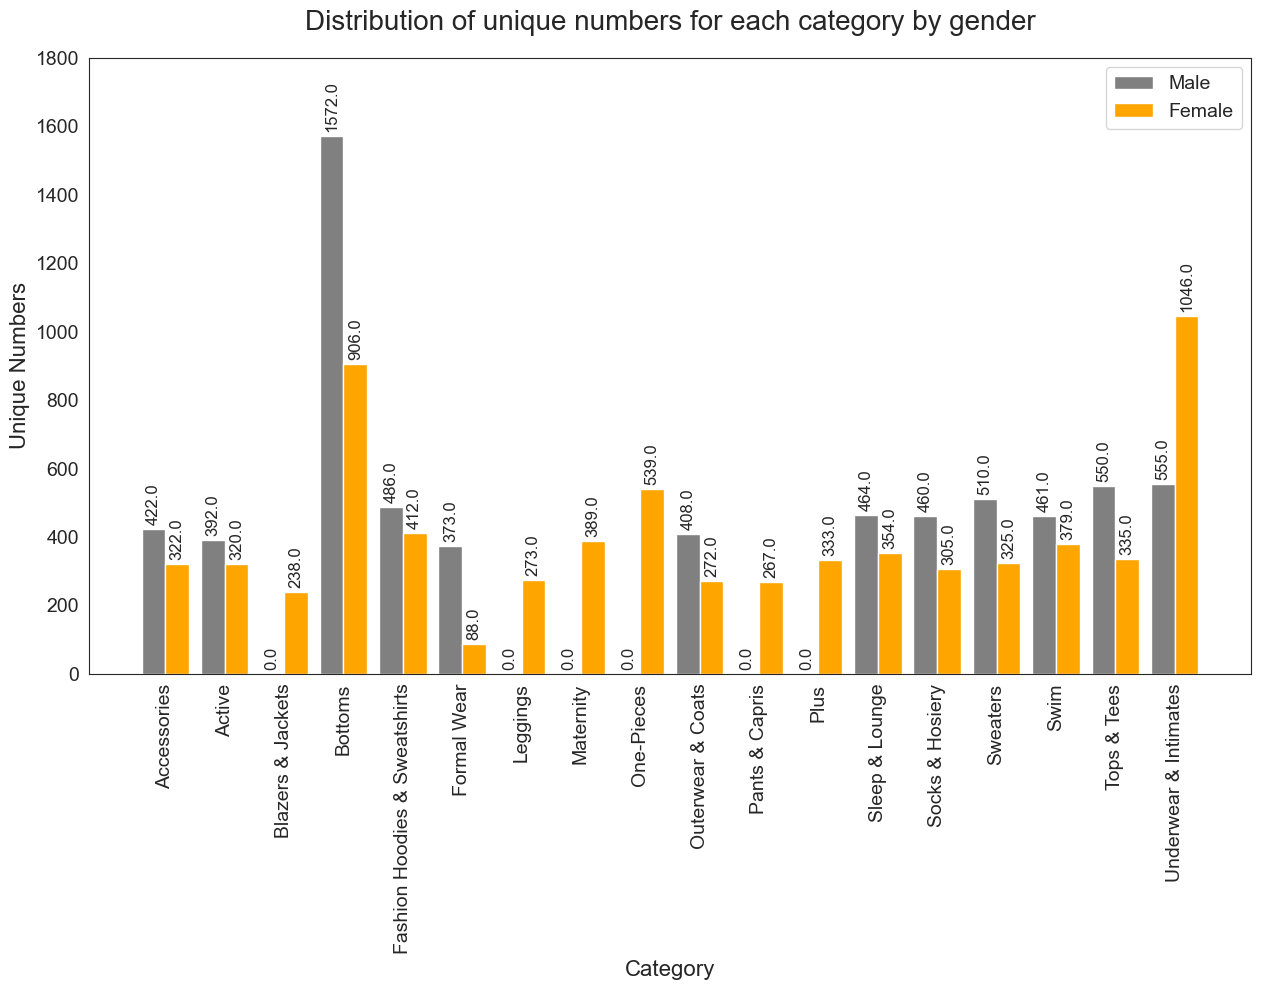

In [23]:
side_by_side_bar(
    depart_cat_matrix, bar1='Men', bar2='Women',
    bar1_label='Male', bar2_label='Female',
    ylim_max=1800, title='Distribution of unique numbers for each category by gender',
    xlabel='Category', ylabel='Unique Numbers',
    figsize=(15, 8), fontsize=14, annotation_fontsize=12
)

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">
    
### 📊 Distribution of Unique Product Categories by Gender – Merged Categories

This section summarizes the unique product category counts (based on `category_merged`) across male and female customers, along with key analytical and technical insights derived from the results.

---

### 👥 Gender Balance per Category

#### ✅ Strong Gender Skew (Highly Gender-Specific)
Some categories are almost exclusive to one gender:

- **Female-dominated:**
  - `Plus`, `Maternity`, and `Leggings` appear **almost exclusively in the women's segment**, confirming their target audience.
  - Example: `One-Pieces` shows **539 unique female customers** and **0 male**, validating it as a women-specific category.

- **Male-represented or Neutral:**
  - `Formal Wear` and `Underwear & Intimates` show **strong presence in both segments**, indicating cross-gender relevance.

---

### 🔁 Merger Effectiveness (category_merged)

- The merged category **`One-Pieces`** consolidates items like dresses, rompers, and jumpsuits under a single, meaningful label.
- This **reduces category fragmentation** and enhances interpretability.
- It also ensures that **clusters reflect true customer behaviors**, not artificial distinctions caused by overly granular subcategories.

---

### 🔍 Strategic Applications

#### 🧩 Use in Matrix Construction
- These distributions are critical when creating:
  - **Customer × Category matrices**
  - **Customer × Category × Department matrices**
  - Especially in gender-specific analysis.

#### 🎯 Marketing Relevance
- **Clearly gendered categories** help with:
  - **More accurate targeting** (e.g., exclude `Maternity` from male campaigns).
  - **Better segment interpretation** for recommendations and promotions.

---

### ⚙️ Technical Takeaways

#### 📌 For Full Matrix: `Customer × category_merged`
- ✅ **Recommended** when:
  - You want to **reduce noise** from tiny or inconsistent categories.
  - **Cross-gender comparisons** are needed.
  - You aim to apply segmentation algorithms like **NMF or SVD**, where sparse, unbalanced input could hinder interpretability.

#### 📌 For Gender-Specific Matrices
- ✅ **Using the original category names** is often more **accurate and detailed**, because:
  - Each matrix contains only **relevant products** for its gender.
  - This **reduces category sparsity** and increases **signal quality**.
  - You preserve more **fine-grained variation** helpful for micro-segmentation.

---

### 🧠 Summary

| Use Case                       | Category Format         | Why?                                                                 |
|-------------------------------|-------------------------|----------------------------------------------------------------------|
| Full Matrix (All Customers)   | `category_merged`       | Reduces clutter, improves interpretability and segmentation clarity |
| Gender-Specific Matrix        | Original `category`     | Enhances detail, relevance, and reduces noise for that gender       |

> Leveraging this dual-level categorization strategy helps align technical modeling precision with actionable business insights.


<br>

- **Create a sparse matrix with `customer_id` x `category_merged`.**

In [24]:
cust_cat_matrix = df.pivot_table(index="customer_id", 
                                 columns="category_merged", 
                                 values="quantity", 
                                 aggfunc="sum", 
                                 )

cust_cat_matrix.head(15)

category_merged,Accessories,Active,Blazers & Jackets,Bottoms,Fashion Hoodies & Sweatshirts,Formal Wear,Leggings,Maternity,One-Pieces,Outerwear & Coats,Pants & Capris,Plus,Sleep & Lounge,Socks & Hosiery,Sweaters,Swim,Tops & Tees,Underwear & Intimates
customer_id,,,,,,,,,,,,,,,,,,
3,NaN,1.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,2.0,NaN,NaN
18,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
30,NaN,NaN,2.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,3.0,NaN
37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
80,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
cust_cat_matrix.shape

(9893, 18)

<br>

- **Calculating data sparsity.**

In [26]:
def Sparsity_Rate(df_matrix):
    """Calculate the sparsity rate (percentage of empty values) in a DataFrame/matrix.
    
    Args:
        df_matrix: Input DataFrame or matrix to analyze
        
    Returns:
        float: Sparsity rate between 0 (no empty values) and 1 (all values empty)
    """
    number_of_empty = df_matrix.isnull().sum().sum()  # Count all null/empty values
    total_number = df_matrix.size                     # Get total number of cells
    sparsity_rate = number_of_empty / total_number    # Calculate empty percentage
    
    return sparsity_rate

In [27]:
print("sparsity rate is:", round(Sparsity_Rate(cust_cat_matrix), 10))

sparsity rate is: 0.9021586531


<br>

- **Fill the empty values in the matrix with the value zero.**

In [28]:
cust_cat_matrix.fillna(0, inplace=True)

cust_cat_matrix.head()

category_merged,Accessories,Active,Blazers & Jackets,Bottoms,Fashion Hoodies & Sweatshirts,Formal Wear,Leggings,Maternity,One-Pieces,Outerwear & Coats,Pants & Capris,Plus,Sleep & Lounge,Socks & Hosiery,Sweaters,Swim,Tops & Tees,Underwear & Intimates
customer_id,,,,,,,,,,,,,,,,,,
3,0.0,1.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0
18,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
30,0.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,3.0,0.0
37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<br>

- **View descriptive matrix summaries.**

In [29]:
cust_cat_matrix.agg(['sum', 'mean', 'std', 'max']).round(3).T.sort_values(by="sum")

,sum,mean,std,max
category_merged,,,,
Blazers & Jackets,642.0,0.065,0.393,6.0
Pants & Capris,983.0,0.099,0.597,6.0
Leggings,1125.0,0.114,0.651,9.0
Formal Wear,1309.0,0.132,0.568,7.0
Plus,1369.0,0.138,0.728,10.0
Maternity,1803.0,0.182,0.899,12.0
One-Pieces,2148.0,0.217,0.902,10.0
Outerwear & Coats,2876.0,0.291,1.044,10.0
Sweaters,3412.0,0.345,1.130,15.0


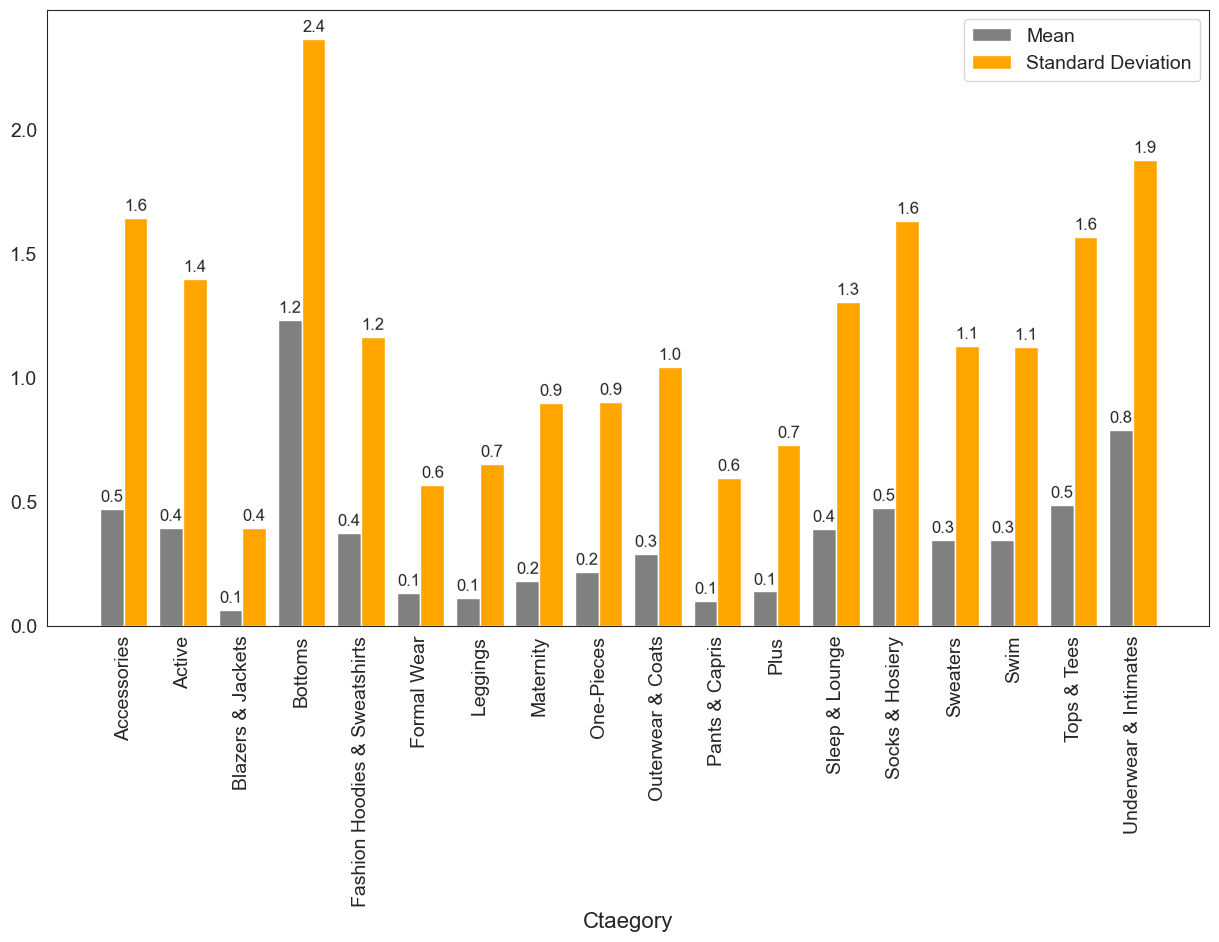

In [30]:
side_by_side_bar(cust_cat_matrix, mode='stats', xlabel='Ctaegory',
                 figsize=(15, 8), annotation_rotation=1)

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">
    
## 📊 Summary of Category Means & Standard Deviations – Merged Product Categories

This statistical overview is based on the **merged product categories** across all customers (regardless of gender), focusing on **mean purchase frequency** and **standard deviation** per category. These insights help evaluate **sparsity**, **purchase concentration**, and **suitability of modeling techniques**.

---

### 🔍 Key Statistical Observations

#### ⚠️ Low-to-Moderate Averages
- **Most means range between 0.10 and 0.50**, indicating that a **typical customer purchased less than one item** in most categories.
- The **highest mean** is in **Bottoms (1.233)**, suggesting that it's the most commonly purchased category.

📌 **Examples**:
- `Tops & Tees` → **mean = 0.489**: On average, less than half the customers purchased an item in this category.
- `Blazers & Jackets` → **mean = 0.065**: Extremely low engagement in this category.

> ✔️ **Implication**: The dataset remains **sparse** (many zeros), although some categories (e.g., Bottoms, Underwear & Intimates) show higher purchasing frequency.

---

#### 📉 High Standard Deviation (STD)
- Most standard deviations range between **1.0 and 2.4**, often exceeding their respective means.
- **Highest STD** is for `Bottoms (2.366)`, followed by `Underwear & Intimates (1.88)` and `Accessories (1.646)`.

📌 **Interpretation**:
- This suggests a **long-tailed distribution**:
  - Few customers buy multiple items.
  - Most customers buy none or very few.
- Reflects **high variability** in customer behavior even within active buyers.

> 🔁 Reinforces the challenge of modeling with distance-based methods (like K-Means) due to skewness and sparsity.

---

### ⚙️ Modeling Implications: K-Means Limitations

#### ❌ Why K-Means Is Not Suitable
- **Extreme Sparsity**:
  - Dominance of zeros distorts Euclidean distances.
- **Long-tail Distributions**:
  - High variability makes centroids less meaningful.
- **Transformations Introduce Bias**:
  - Applying log or Box-Cox transformations requires a shift, which can **inflate rare categories** or distort patterns.
- **No Discovery of Latent Structure**:
  - K-Means clusters based on raw space, missing hidden themes in customer behavior.

---

### ✅ Superior Alternatives: NMF vs. SVD

| Feature               | NMF                                  | SVD                                |
|-----------------------|---------------------------------------|-------------------------------------|
| Handles sparsity      | ✅ Yes – Designed for sparse data      | ⚠️ Partially – Mixed performance     |
| Interpretability      | ✅ High – Non-negative & intuitive     | ❌ Low – Mixed signs complicate use |
| Long-tail robustness  | ✅ Strong – Focus on presence & volume | ⚠️ Weak – Noise from high-variance  |
| Latent pattern clarity| ✅ Clear, additive profiles            | ❌ Blurred by sign mix & variance   |

---

### 🧠 Why NMF Works Better in This Context

- **Keeps zero entries intact**, modeling actual non-purchase behavior.
- **Non-negativity constraint** ensures **interpretability** and **realistic segments**.
- **Reduces noise** from high-variance categories by extracting dominant structure.
- **Generates compact customer profiles** for targeted marketing and personalized recommendations.

---

### 🚀 Final Recommendation

Use **Non-negative Matrix Factorization (NMF)** for:

- Managing high sparsity (>90% zeros in some categories)
- Extracting meaningful, **actionable customer segments**
- Supporting **interpretable marketing strategies**
- Avoiding pitfalls of K-Means and over-transformation

---

### 📌 Conclusion

In highly sparse, skewed retail datasets like this one, **NMF clearly outperforms both K-Means and SVD**, offering better segmentation quality and stronger business relevance.



<a id="NMF"></a>
# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Georgia;text-align:center;display:fill;border-radius:30px;background-color:#404040;overflow:hidden"><b>Applying the NMF algorithm to Merged Categories</b></div>

<a id="Scale"></a>
# <div style="padding:20px;color:white;margin:0;font-size:25px;font-family:Georgia;text-align:center;display:fill;border-radius:30px;background-color:#404040;overflow:hidden"><b>⚖️ Scaling Strategy Before NMF – Merged Product Categories</b></div>

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">
    
To ensure **NMF stability and interpretability**, proper scaling of the data is a crucial preprocessing step. Here's how and why we scale the data:

---

### 🔧 Column Scaling Approach

- We apply `StandardScaler(with_mean=False)` before fitting the NMF model.
- ➤ This standardizes each **product category (column)** while preserving **non-negativity**, a core requirement for NMF.

---

### ✅ Why Use `with_mean=False`?

- **Preserves non-negative values**:
  - Avoids introducing negative values into the matrix.
  - Ensures compatibility with NMF, which only handles non-negative inputs.
- **Balances scale**:
  - Reduces the influence of **larger-value categories** that could otherwise dominate the factorization.

---

### 💡 Benefits of Scaling in This Context

1. **⏱️ Faster Convergence**  
   - Scaling speeds up training by requiring **fewer iterations** to reach convergence.
   - This is especially useful with **large, sparse datasets**.

2. **📉 Enhanced Numerical Stability**  
   - Mitigates **fluctuations** due to classes with high variance.
   - Helps the algorithm focus on **real purchasing patterns**, not raw magnitude differences.

3. **📊 Fair Comparison Across Categories**  
   - Categories like *Tops* or *Jeans* may naturally have more purchases.
   - Scaling ensures **equal consideration** for lower-volume but still meaningful categories.

---

### 🔄 Summary of Preprocessing Step

| Step                   | Technique                            | Purpose                                 |
|------------------------|--------------------------------------|------------------------------------------|
| Column Scaling         | `StandardScaler(with_mean=False)`   | Normalize ranges without introducing negatives |
| Preserve Non-Negativity | ✅ Yes                              | Required for NMF                         |
| Optimize NMF Convergence | ✅ Yes                            | Reduces computation time and instability |

---

### 🚀 Final Takeaway

> Scaling columns using `StandardScaler(with_mean=False)` is a **foundational step** in preparing sparse purchase data for NMF.  
> It improves **efficiency**, **stability**, and **interpretability**—allowing the NMF to extract meaningful, balanced customer segments from a highly imbalanced matrix.


<br>

- **Standardize and scale matrix with StandardScaler.**

In [31]:
scaler = StandardScaler(with_mean=False)

X_scaled = scaler.fit_transform(cust_cat_matrix)

X_scaled

array([[0.        , 0.71414906, 0.        , ..., 1.77832725, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 3.1885888 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        4.25552095],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        3.19164072],
       [3.64519435, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 2.55087104,
        0.        ]])

<a id="Deter"></a>
# <div style="padding:20px;color:white;margin:0;font-size:22px;font-family:Georgia;text-align:center;display:fill;border-radius:30px;background-color:#404040;overflow:hidden"><b>🔢 Determining the Optimal Number of Components – Merged Product Categories</b></div>

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">
    
To choose the most effective number of components (`n_components`) for dimensionality reduction via **Non-negative Matrix Factorization (NMF)**, we rely on a **dual-metric validation approach** using:

- **Reconstruction Error**
- **Silhouette Score**

---

### 📊 Methodological Approach

#### 1. **Reconstruction Error** (Elbow Method)

- **Definition**: Measures how accurately the reduced-dimension representation can **reconstruct the original data**.
- **Interpretation**:  
  - **Lower values** = Better reconstruction.
  - Watch for the **“elbow point”**, where improvements level off — indicating diminishing returns from adding more components.

#### 2. **Silhouette Score**

- **Definition**: Evaluates the **quality of clustering** by measuring how similar a sample is to its own cluster vs. other clusters.
- **Scale**: Ranges from -1 to 1
  - Closer to **1** = Well-separated, cohesive clusters.
  - Closer to **0** = Overlapping or ambiguous clusters.

---

### ✅ Optimal Component Selection Criteria

> The optimal `n_components` lies at the **intersection** where both metrics stabilize or peak:

| Criterion                         | Signal for Optimal Point                  |
|----------------------------------|-------------------------------------------|
| 🔻 **Reconstruction Error**      | Begins to **flatten** (elbow)             |
| 🔺 **Silhouette Score**          | **Peaks** or reaches near-maximum         |

This ensures that:
- The model captures **enough latent structure**.
- The customer segments are **distinct and interpretable**.
- We avoid **underfitting** (too few components) and **overfitting** (too many components).

---

### 🧠 Why This Dual Approach Works

- **Reconstruction Error** tells us how **faithfully the model learns** from the data.
- **Silhouette Score** tells us how **usefully it separates** customer types.

Together, they provide a **balanced framework** that optimizes both **statistical fidelity** and **business usability**.

---

### 📌 Final Note

> Applying both metrics provides a **data-driven, interpretable selection** for NMF that balances **complexity**, **segmentation clarity**, and **model performance**.


In [32]:
def elbow_components(df_matrix, range_max=10, Solver='cd', Beta_loss='frobenius'):
    """Perform NMF component analysis using elbow method and silhouette scores.
    
    Args:
        df_matrix: Input data matrix
        range_max: Max number of components to test (default 10)
        Solver: NMF solver algorithm (default 'cd')
        Beta_loss: Loss function (default 'frobenius')
        
    Returns:
        Plot showing reconstruction error and silhouette scores
    """
    
    # Initialize metrics storage
    reconstruction_errors = []
    silhouette_scores = []
    components_range = range(2, range_max)  # Start from 2 components

    for n in components_range:
        # Train NMF model
        model = NMF(
            n_components=n,
            init='nndsvda',  # Most stable initialization
            solver=Solver,   # Coordinate Descent solver
            max_iter=1000,   # Sufficient iterations for convergence
            beta_loss=Beta_loss,
            random_state=42  # Reproducibility
        )
        
        W = model.fit_transform(df_matrix)
        
        # Store reconstruction error
        reconstruction_errors.append(model.reconstruction_err_)
        
        # Calculate and store silhouette score
        W_normalized = W / np.sum(W, axis=1, keepdims=True)  # Normalize to probabilities
        assigned_clusters = np.argmax(W_normalized, axis=1)
        silhouette_scores.append(silhouette_score(W, assigned_clusters))

    # Create dual-axis plot
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot reconstruction error (primary axis)
    ax1.plot(components_range, reconstruction_errors, 'o-', color='b', label='Reconstruction Error')
    ax1.set_xlabel('Number of Components')
    ax1.set_ylabel('Reconstruction Error', color='b')
    ax1.tick_params('y', colors='b')
    ax1.grid(True)
    
    # Plot silhouette score (secondary axis)
    ax2 = ax1.twinx()
    ax2.plot(components_range, silhouette_scores, 'o--', color='r', label='Silhouette Score')
    ax2.set_ylabel('Silhouette Score', color='r')
    ax2.tick_params('y', colors='r')
    
    # Finalize plot
    plt.title('NMF Component Analysis', fontsize=16, pad=20)
    fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes);

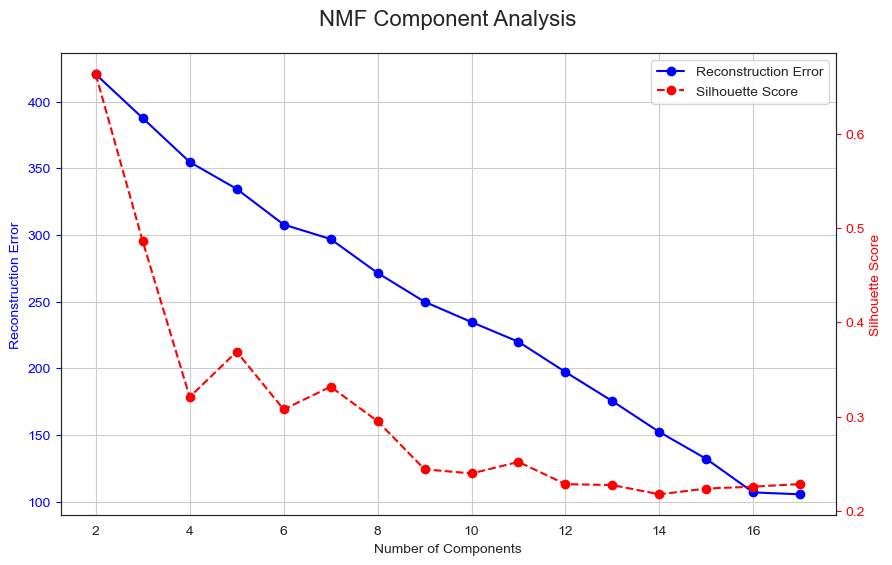

In [33]:
# Run NMF component analysis with optimized parameters for sparse data

elbow_components(X_scaled,                     # Preprocessed/scaled input matrix
                 range_max=18,                 # Test up to 17 components (starts from 2)
                 Solver='mu',                  # Multiplicative Update algorithm (better for sparsity)
                 Beta_loss='kullback-leibler'  # KL divergence loss (optimal for sparse counts)
                )

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">
    
### 📊 Optimal Component Selection for NMF on Combined Categories

This section summarizes the model evaluation process used to determine the ideal number of components (**n_components**) for segmenting customers based on their behavior across **combined categories** (i.e., grouped or consolidated product types).

---

### 📈 Key Metric Trends

#### 🧩 1. Reconstruction Error
- **Observation:**  
  The reconstruction error **steadily decreases** as the number of components increases.
- **Implication:**  
  Higher component counts allow better data approximation and capture more nuance in customer behavior.

#### 📊 2. Silhouette Score
- **Observation:**
  - **Peak score = 0.66** when `n_components = 2`.
  - Score **drops sharply** to around **0.22** at `n_components = 16`.
- **Implication:**  
  - A high silhouette score at 2 components suggests **clear and well-separated segments** initially.
  - As more components are added, segments become **less distinct**, reducing clustering quality.

---

### ⚖️ Interpretation & Trade-offs

- Increasing the number of components improves reconstruction (technical accuracy) but may reduce **segment clarity**.
- A **trade-off** exists between capturing complex patterns and maintaining actionable, interpretable customer groups.
- Too many components risk **overfitting** and create segments that are harder to interpret and apply.

---

### ✅ Recommendation: Use `n_components = 5`

Choosing **5 components** strikes the best balance between statistical soundness and business practicality:

- 🎯 **Captures meaningful market distinctions** without segment overlap.
- 🧠 **Preserves interpretability** of segments—each group remains clear and usable.
- 💼 **Enables actionable marketing** by keeping the number of segments manageable.
- 🚫 **Avoids segment degradation** observed at higher component counts (e.g., 10+).

---

### 🏁 Final Verdict

> Select **5 components** to optimize both model performance and real-world application.  
> This choice supports clear, well-separated customer profiles while maintaining robust data representation—ideal for marketing segmentation and campaign targeting.


<br>

- **Convert the scaled array back to a data frame.**

In [34]:
X_scaled_df = pd.DataFrame(X_scaled, index=cust_cat_matrix.index, columns=cust_cat_matrix.columns)
X_scaled_df

category_merged,Accessories,Active,Blazers & Jackets,Bottoms,Fashion Hoodies & Sweatshirts,Formal Wear,Leggings,Maternity,One-Pieces,Outerwear & Coats,Pants & Capris,Plus,Sleep & Lounge,Socks & Hosiery,Sweaters,Swim,Tops & Tees,Underwear & Intimates
customer_id,,,,,,,,,,,,,,,,,,
3,0.000000,0.714149,0.000000,4.649033,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,3.827366,0.0,0.0,1.778327,0.000000,0.000000
18,0.000000,0.000000,0.000000,0.845279,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,3.188589,0.000000
20,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,4.255521
30,0.000000,0.000000,5.091769,0.000000,0.0,0.000000,0.0,5.562824,0.000000,0.0,0.0,6.865235,0.000000,0.0,0.0,0.000000,1.913153,0.000000
37,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,2.216932,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99939,0.000000,0.000000,0.000000,0.000000,0.0,1.761646,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.889164,0.000000,0.000000
99951,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.530946,0.0,0.0,0.000000,0.000000,0.000000
99956,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,3.325398,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,3.191641


<br>

- **Applying the 5-component NMF algorithm to our scaled data matrix.**

In [35]:
def NMF_Model(df_matrix, N_components, Init='random'):
    """Train NMF model and return components with readable DataFrames.
    
    Args:
        df_matrix: Input data matrix (customers x features)
        N_components: Number of latent patterns to extract
        Init: Initialization method (default 'random')
        
    Returns:
        W: Customer embeddings matrix
        H: Feature patterns matrix  
        segment_W_df: Customer patterns (DataFrame)
        segment_H_df: Pattern features (DataFrame)
    """
    
    # Initialize and train NMF model
    nmf_model = NMF(
        n_components=N_components,
        init=Init,               # 'random' or 'nndsvda' 
        solver='mu',             # Multiplicative Update (best for sparse data)
        max_iter=1000,           # Ensure convergence
        beta_loss='kullback-leibler',  # Optimal for count/sparse data
        random_state=42          # Reproducibility
    )
    
    nmf_model.fit(df_matrix)

    # Extract model components
    W = nmf_model.transform(df_matrix)  # Customer embeddings
    H = nmf_model.components_          # Feature patterns
    
    # Create readable DataFrames
    patterns = [f'Pattern_{i+1}' for i in range(N_components)]
    
    segment_W_df = pd.DataFrame(
        W, 
        index=df_matrix.index,    # Preserve customer IDs
        columns=patterns
    )
    
    segment_H_df = pd.DataFrame(
        H,
        index=patterns,           # Pattern labels
        columns=df_matrix.columns # Original features
    )
    
    return W, H, segment_W_df, segment_H_df

In [36]:
# Train NMF model with 5 components using optimized parameters
W, H, segment_W_df, segment_H_df = NMF_Model(X_scaled_df,    # Preprocessed input matrix
                                             5,              # Number of latent patterns to extract
                                             'nndsvda'       # Stable initialization for sparse data
                                            )

# Inspect customer embeddings matrix
print("Customer-Pattern Matrix (W):")
print(W)  # Raw numpy array of customer embeddings
print("\nMatrix Shape:", W.shape)  # Dimensions: (n_customers, 5)

Customer-Pattern Matrix (W):
[[1.08012677e-001 1.46216717e-234 9.22189025e-102 2.23633823e-001
  7.38812876e-002]
 [8.12407376e-002 5.10286899e-247 3.22019715e-114 1.94220685e-154
  7.92836352e-161]
 [8.57047631e-002 2.59523022e-041 4.97443025e-181 2.85413647e-150
  8.43038322e-177]
 ...
 [6.35631390e-002 1.29614453e-001 3.68929789e-181 2.11677702e-150
  6.25241353e-177]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.12989490e-001
  0.00000000e+000]
 [8.54209458e-002 2.05942943e-241 1.30155582e-108 7.79492914e-149
  3.15031476e-155]]

Matrix Shape: (9893, 5)


In [37]:
# Analyze the NMF components (patterns)
print("Pattern-Product Matrix (H):")
print(H)  # Raw component matrix showing each pattern's product weights
print("\nMatrix Dimensions:", H.shape)  # Format: (n_patterns, n_products)

Pattern-Product Matrix (H):
[[0.00000000e+00 7.71788662e+00 0.00000000e+00 1.43015478e+01
  0.00000000e+00 7.49223484e-16 0.00000000e+00 0.00000000e+00
  0.00000000e+00 7.64037966e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 4.11795148e-16 1.19041144e-15
  8.55471176e+00 1.14387350e+01]
 [0.00000000e+00 1.04930319e-14 4.42873528e+00 1.95798801e-11
  0.00000000e+00 0.00000000e+00 1.05674980e-13 5.43534433e+00
  6.45152948e+00 1.26535826e-15 4.45814960e+00 5.09324887e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.86040679e-16 6.31384233e-02]
 [0.00000000e+00 4.61007719e-13 0.00000000e+00 6.00694111e-05
  9.55911441e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.19879340e-15 0.00000000e+00 0.00000000e+00
  0.00000000e+00 8.66261055e+00 4.21419625e-12 0.00000000e+00
  1.64177971e-13 4.58361426e-09]
 [8.39188854e+00 3.01516236e-15 0.00000000e+00 5.49781708e-07
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.0

In [38]:
# Preview customer segmentation results
print("Customer Pattern Assignments (Top 5 Rows):")
display(segment_W_df.head())  # Shows first 5 customers' pattern weights

# Expected output columns:
# - Rows: Customer IDs (index)
# - Columns: Pattern_1 to Pattern_N weights
# - Values: Strength of association (0-1)

Customer Pattern Assignments (Top 5 Rows):


,Pattern_1,Pattern_2,Pattern_3,Pattern_4,Pattern_5
customer_id,,,,,
3,0.108013,1.462167e-234,9.221890e-102,2.236338e-01,7.388129e-02
18,0.081241,5.102869e-247,3.220197e-114,1.942207e-154,7.928364e-161
20,0.085705,2.595230e-41,4.974430e-181,2.854136e-150,8.430383e-177
30,0.038530,6.756548e-01,9.018393e-268,2.460190e-217,4.688787e-216
37,0.000000,8.549632e-02,0.000000e+00,0.000000e+00,0.000000e+00


In [39]:
# Analyze product patterns discovered by NMF
print("Product Pattern Components:")
display(segment_H_df)  # Shows all patterns and their product weights

# DataFrame Structure:
# - Rows: Discovered patterns (Pattern_1 to Pattern_N)
# - Columns: Product categories
# - Values: Weight of each product in the pattern (higher = more representative)

Product Pattern Components:


category_merged,Accessories,Active,Blazers & Jackets,Bottoms,Fashion Hoodies & Sweatshirts,Formal Wear,Leggings,Maternity,One-Pieces,Outerwear & Coats,Pants & Capris,Plus,Sleep & Lounge,Socks & Hosiery,Sweaters,Swim,Tops & Tees,Underwear & Intimates
Pattern_1,0.000000,7.717887e+00,0.000000,1.430155e+01,0.000000,7.492235e-16,0.000000e+00,0.000000,0.000000,7.640380e+00,0.00000,0.000000,0.000000,0.000000,4.117951e-16,1.190411e-15,8.554712e+00,1.143873e+01
Pattern_2,0.000000,1.049303e-14,4.428735,1.957988e-11,0.000000,0.000000e+00,1.056750e-13,5.435344,6.451529,1.265358e-15,4.45815,5.093249,0.000000,0.000000,0.000000e+00,0.000000e+00,3.860407e-16,6.313842e-02
Pattern_3,0.000000,4.610077e-13,0.000000,6.006941e-05,9.559114,0.000000e+00,0.000000e+00,0.000000,0.000000,4.198793e-15,0.00000,0.000000,0.000000,8.662611,4.214196e-12,0.000000e+00,1.641780e-13,4.583614e-09
Pattern_4,8.391889,3.015162e-15,0.000000,5.497817e-07,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.944352e-10,0.00000,0.000000,8.722544,0.000000,2.882245e-14,1.875235e-15,5.127179e-11,1.485649e-07
Pattern_5,0.000000,3.327427e-13,0.000000,3.702432e-07,0.000000,5.499029e+00,4.121753e+00,0.000000,0.000000,6.428253e-13,0.00000,0.000000,0.000000,0.000000,7.201894e+00,7.247388e+00,8.355987e-11,9.852571e-09


<br>

- **Allocate the segment based on the highest weight for each customer.**

In [40]:
def Segment_Category_NMF(df_matrix, weight_matrix):
    """Assign customers to segments based on NMF weights.
    
    Args:
        df_matrix: Original customer-product matrix
        weight_matrix: NMF weight matrix (W)
        
    Returns:
        DataFrame with original data + segment assignments
    """
    # Normalize weights to probabilities (sum to 1 per customer)
    W_normalized = normalize(weight_matrix, norm='l1', axis=1)
    
    # Assign each customer to strongest pattern (segment)
    assigned_segment = np.argmax(W_normalized, axis=1) + 1  # +1 for 1-based numbering
    
    # Add segment column to original DataFrame
    segment_category_nmf = df_matrix.assign(segment=assigned_segment)
    
    return segment_category_nmf

In [41]:
segment_category_nmf = Segment_Category_NMF(X_scaled_df, W)

segment_category_nmf

category_merged,Accessories,Active,Blazers & Jackets,Bottoms,Fashion Hoodies & Sweatshirts,Formal Wear,Leggings,Maternity,One-Pieces,Outerwear & Coats,Pants & Capris,Plus,Sleep & Lounge,Socks & Hosiery,Sweaters,Swim,Tops & Tees,Underwear & Intimates,segment
customer_id,,,,,,,,,,,,,,,,,,,
3,0.000000,0.714149,0.000000,4.649033,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,3.827366,0.0,0.0,1.778327,0.000000,0.000000,4
18,0.000000,0.000000,0.000000,0.845279,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,3.188589,0.000000,1
20,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,4.255521,1
30,0.000000,0.000000,5.091769,0.000000,0.0,0.000000,0.0,5.562824,0.000000,0.0,0.0,6.865235,0.000000,0.0,0.0,0.000000,1.913153,0.000000,2
37,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,2.216932,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99939,0.000000,0.000000,0.000000,0.000000,0.0,1.761646,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.889164,0.000000,0.000000,5
99951,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.530946,0.0,0.0,0.000000,0.000000,0.000000,4
99956,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,3.325398,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,3.191641,2


<br>

- **Show a heat map of the segment centers for each category.**

In [42]:
def heat_map_segments(df_matrix_nmf, Title):
    """Visualize segment purchase patterns using a heatmap.
    
    Args:
        df_matrix_nmf: DataFrame with segment assignments
        Title: Chart title string
        
    Returns:
        DataFrame: Average purchase values per segment
    """
    # Calculate segment averages
    nmf_average = df_matrix_nmf.groupby('segment').mean().round(2)
    
    # Create heatmap visualization
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        nmf_average.T,          # Transpose for better readability
        cmap="YlGnBu",          # Color scheme
        annot=True,             # Show values
        fmt=".2f"              # Value formatting
    )
    
    # Add labels and title
    plt.title(Title, fontsize=16, pad=20)
    plt.xlabel("Segment", fontsize=12)
    plt.ylabel("Product Category", fontsize=12)
    
    return nmf_average

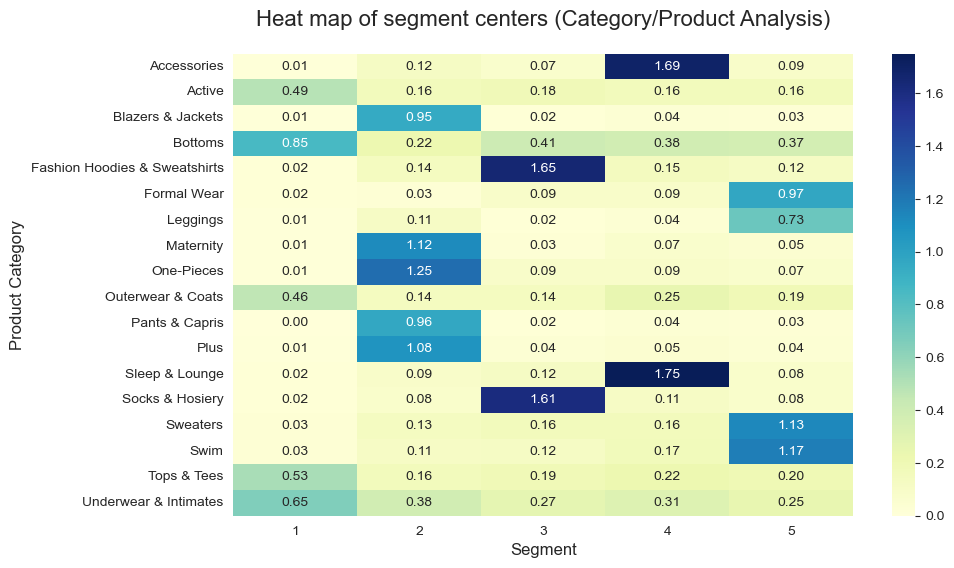

In [43]:
nmf_average = heat_map_segments(segment_category_nmf, 'Heat map of segment centers (Category/Product Analysis)')

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">
    
### 🧩 Segment Profiles Based on Merged Product Categories (Using NMF with 5 Components)

A refined **Non-Negative Matrix Factorization (NMF)** model was applied to the **customer × merged product category** matrix using **5 components** to extract interpretable and actionable customer segments. Below is a summary of the resulting segment profiles.

---

### 🧩 Segment Profiles Based on Merged Categories (NMF with 5 Components)

| Segment | Key High-Weight Categories | Notable Weights | Behavioral Interpretation |
|--------:|----------------------------|------------------|----------------------------|
| **1**   | Bottoms, Outerwear & Coats, Underwear & Intimates, Tops & Tees | `Bottoms (0.85)`, `Outerwear (0.46)`, `Underwear (0.65)`, `Tops (0.53)` | Practical and essentials-oriented customers; favor everyday clothing |
| **2**   | One-Pieces, Maternity, Plus, Blazers & Jackets | `One-Pieces (1.25)`, `Maternity (1.12)`, `Plus (1.08)`, `Blazers (0.95)` | Likely maternity or plus-size customers seeking comfort and coverage |
| **3**   | Fashion Hoodies & Sweatshirts, Socks & Hosiery | `Hoodies (1.65)`, `Socks & Hosiery (1.61)` | Cozy, lounge-oriented shoppers; potentially younger, casual buyers |
| **4**   | Sleep & Lounge, Accessories | `Sleep & Lounge (1.75)`, `Accessories (1.69)` | Gift-focused or minimal apparel buyers, prioritizing comfort and extras |
| **5**   | Swim, Sweaters | `Swim (1.17)`, `Sweaters (1.13)` | Seasonally driven customers with interest in both warm and cold weather apparel |

> ✅ **Note**: Weights reflect average component contributions per segment. Higher values denote stronger category associations.

---

### 📈 Key Insights

- **Clear differentiation** between segments: practical vs. comfort-driven vs. seasonal vs. special-size shoppers.
- **Merged categories** maintained clarity while reducing sparsity and improving interpretability.
- **Latent themes** such as "maternity comfort", "loungewear loyalty", and "seasonal versatility" emerged naturally.
- The model continues to perform well under **high sparsity conditions**, validating the strength of NMF.

---

### 🎯 Marketing Applications

- **Segmented targeting**: Tailor promotions and campaigns based on the dominant categories in each segment.
- **Product bundling**: Combine categories with shared interest within segments (e.g., sleepwear + accessories).
- **Personalized recommendations**: Use segment profile weights to power recommender systems.
- **Landing pages**: Curate collections like "Comfort Zone", "Seasonal Picks", or "Maternity Essentials" for each group.



<br>

- **Extract demographic information.**

In [44]:
customer_info = df[["customer_id","age", "gender", "region"]].groupby("customer_id").max().reset_index()

customer_info

,customer_id,age,gender,region
0,3,16,M,South
1,18,17,M,West
2,20,13,M,South
3,30,16,F,West
4,37,34,F,Northeast
...,...,...,...,...
9888,99939,66,M,West
9889,99951,25,M,South
9890,99956,56,F,Northeast
9891,99985,45,M,West


<br>

- **concating demographic information with W results.**

In [45]:
Demographic_segment = pd.concat([customer_info.reset_index(drop=True), segment_category_nmf.reset_index(drop=True)], axis=1)

Demographic_segment

,customer_id,age,gender,region,Accessories,Active,Blazers & Jackets,Bottoms,Fashion Hoodies & Sweatshirts,Formal Wear,Leggings,Maternity,One-Pieces,Outerwear & Coats,Pants & Capris,Plus,Sleep & Lounge,Socks & Hosiery,Sweaters,Swim,Tops & Tees,Underwear & Intimates,segment
0,3,16,M,South,0.000000,0.714149,0.000000,4.649033,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,3.827366,0.0,0.0,1.778327,0.000000,0.000000,4
1,18,17,M,West,0.000000,0.000000,0.000000,0.845279,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,3.188589,0.000000,1
2,20,13,M,South,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,4.255521,1
3,30,16,F,West,0.000000,0.000000,5.091769,0.000000,0.0,0.000000,0.0,5.562824,0.000000,0.0,0.0,6.865235,0.000000,0.0,0.0,0.000000,1.913153,0.000000,2
4,37,34,F,Northeast,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,2.216932,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9888,99939,66,M,West,0.000000,0.000000,0.000000,0.000000,0.0,1.761646,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.889164,0.000000,0.000000,5
9889,99951,25,M,South,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.530946,0.0,0.0,0.000000,0.000000,0.000000,4
9890,99956,56,F,Northeast,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,3.325398,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,3.191641,2
9891,99985,45,M,West,3.645194,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,4


<br>

- **Create a data frame for a summary of age, gender, and region for each segment.**

In [46]:

# Initialize empty summary DataFrame with proper schema
summary = pd.DataFrame({
    'Segment': pd.Series(dtype='int'),
    'Top 2 Categories': pd.Series(dtype='object'),
    'Avg Age': pd.Series(dtype='float'),
    'Male %': pd.Series(dtype='float'), 
    'Female %': pd.Series(dtype='float'),
    'Top Region': pd.Series(dtype='object'),
    'Customer Count': pd.Series(dtype='int')
})

categories = segment_H_df.columns  # Get product categories

for segment in sorted(Demographic_segment['segment'].unique()):
    seg_data = Demographic_segment[Demographic_segment['segment'] == segment]

    # Behavioral features
    top_categories = (seg_data[categories].mean()         # Avg purchase per category
                      .sort_values(ascending=False)       # Rank categories
                      .head(2).index.tolist())           # Get top 2

    # Demographic features
    avg_age = seg_data['age'].mean()
    male_ratio = (seg_data['gender'] == 'M').mean() * 100
    female_ratio = (seg_data['gender'] == 'F').mean() * 100
    top_region = seg_data['region'].value_counts().idxmax()

    # Append segment summary
    summary = pd.concat([
        summary,
        pd.DataFrame({
            'Segment': [segment],
            'Top 2 Categories': [', '.join(top_categories)],
            'Avg Age': [round(avg_age, 1)],
            'Male %': [round(male_ratio, 1)],
            'Female %': [round(female_ratio, 1)],
            'Top Region': [top_region],
            'Customer Count': [seg_data.shape[0]]
        })
    ], ignore_index=True)


In [47]:
summary

,Segment,Top 2 Categories,Avg Age,Male %,Female %,Top Region,Customer Count
0,1,"Bottoms, Underwear & Intimates",41.0,58.4,41.6,South,3477
1,2,"One-Pieces, Maternity",41.1,0.0,100.0,South,1546
2,3,"Fashion Hoodies & Sweatshirts, Socks & Hosiery",41.1,60.6,39.4,South,1484
3,4,"Sleep & Lounge, Accessories",41.1,59.7,40.3,South,1380
4,5,"Swim, Sweaters",40.7,58.3,41.7,South,2006


 <br>

- **Show the number of customers per segment.**

In [48]:
def cust_segment_countplot(df_segment, Title, ylim_max):
    """Visualize customer distribution across segments with counts.
    
    Args:
        df_segment: DataFrame containing 'segment' column
        Title: Chart title string
        ylim_max: Maximum y-axis value for consistent scaling
    """
    plt.figure(figsize=(10, 6))
    
    # Create countplot
    ax = sns.countplot(
        x='segment', 
        data=df_segment,
        order=sorted(df_segment['segment'].unique())  # Ordered segments
    )
    
    # Add count labels on bars
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.0f}',          # Format count as integer
            (p.get_x() + p.get_width()/2., p.get_height()),  # Center position
            ha='center', 
            va='center', 
            xytext=(0, 5),                   # Vertical offset
            textcoords='offset points'
        )
    
    # Formatting
    plt.title(Title, fontsize=16, pad=20)
    plt.xlabel('Customer Segment', fontsize=14)
    plt.ylabel('Number of Customers', fontsize=14)
    plt.ylim(0, ylim_max)  # Consistent axis scaling
    plt.tight_layout()      # Prevent label clipping

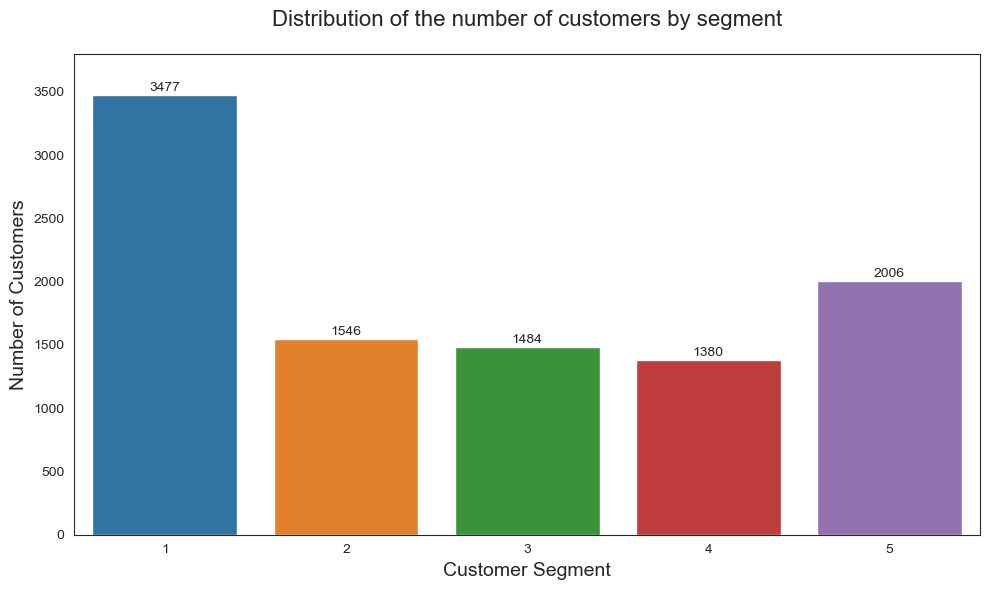

In [49]:
cust_segment_countplot(Demographic_segment, 'Distribution of the number of customers by segment', 3800)

<br>

- **Show the percentage of each gender in its acquisition of each segment.**

In [50]:
segment_gender_matrix = summary[["Male %", "Female %"]].T.rename(columns=lambda x: x+1) / 100
segment_gender_matrix

,1,2,3,4,5
Male %,0.584,0.0,0.606,0.597,0.583
Female %,0.416,1.0,0.394,0.403,0.417


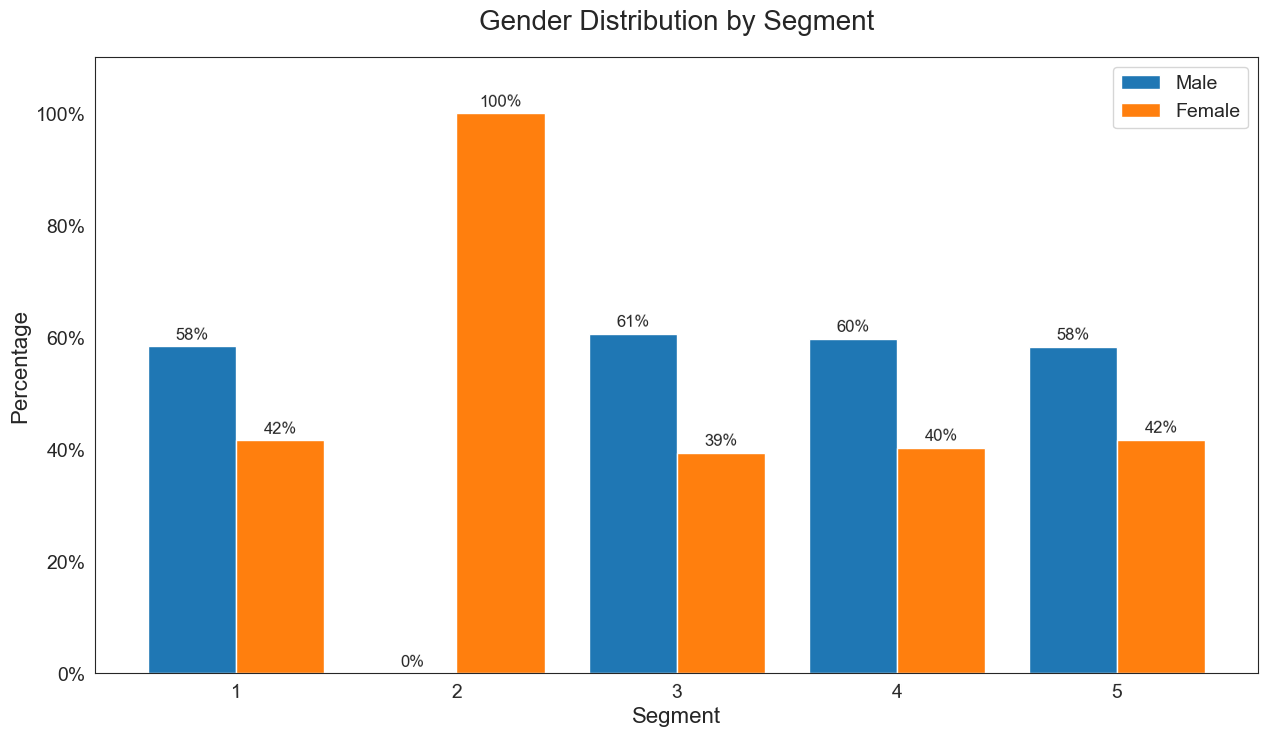

In [51]:
side_by_side_bar(
    segment_gender_matrix,
    bar1='Male %', 
    bar2='Female %',
    bar1_label='Male', 
    bar2_label='Female', 
    use_percentage=True,
    colors=('#1f77b4', '#ff7f0e'),
    title='Gender Distribution by Segment',
    xlabel='Segment',
    ylabel='Percentage',
    xlabel_rotation=1,
    annotation_rotation=1
)

<br>

- **Show age distribution for each segment.**

In [52]:
def cust_segment_age_boxplot(df_segment, Title):
    """Visualize age distribution across customer segments using boxplots.
    
    Args:
        df_segment: DataFrame containing 'segment' and 'age' columns
        Title: Chart title string
    """
    plt.figure(figsize=(12, 6))
    
    # Create boxplot with enhanced styling
    sns.boxplot(
        x='segment',
        y='age',
        data=df_segment,
        palette="Blues",          # Color scheme
        showmeans=True,           # Show mean markers
        meanprops={"marker":"o",  # Mean point styling
                   "markerfacecolor":"white",
                   "markeredgecolor":"black"}
    )
    
    # Formatting
    plt.title(Title, fontsize=18, pad=20)
    plt.xlabel('Customer Segment', fontsize=14)
    plt.ylabel('Age Distribution', fontsize=14)
    plt.grid(axis='y', alpha=0.3)  # Light grid for reference
    plt.tight_layout()

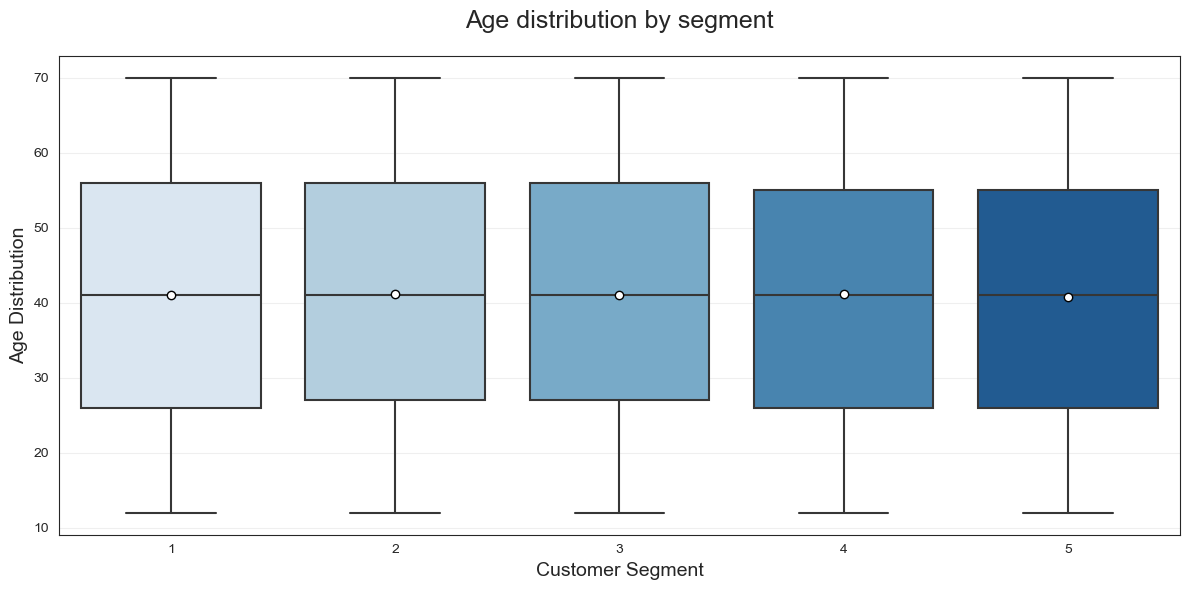

In [53]:
cust_segment_age_boxplot(Demographic_segment, 'Age distribution by segment')

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">
    
### 📊 Demographic Insights for Merged Segments (Age, Gender, and Region)

This section summarizes key demographic patterns—age, gender distribution, and geographic concentration—for the five customer segments derived from the **merged category segmentation**.

---

### 🧠 Key Insights

#### 🎂 **Uniform Age Profile**
- All five segments average around **41 years old**.
- ➤ This indicates a consistent **middle-aged customer base**, with **no major generational splits** across segments.
- ✅ **Implication:** Age-specific campaigns are **not immediately necessary**, as age is uniformly distributed.

---

#### 🚻 **Gender Composition**
- **Segment 2** *(One-Pieces & Maternity)*:
  - **100% Female**
  - ➤ This matches the product focus perfectly—ideal for **female-exclusive campaigns**.
- **Segments 1, 3, 4, and 5**:
  - **Mixed Gender** with a slight **male skew**:
    - ~**58–61% Male**
    - ~**39–42% Female**
  - ✅ **Implication:** Mixed campaigns are appropriate, but messaging can lean slightly **male-oriented**.

---

#### 📍 **Geographic Concentration**
- **Top Region for All Segments:** `South`
- ➤ This may be due to:
  - Biased sampling in the dataset
  - Or actual customer dominance in the southern region
- ✅ **Implication:**
  - Strong justification for **regionally tailored campaigns** focused on the South.
  - If expansion is a goal, you should collect or analyze data from **non-South** regions.

---

#### 👥 **Segment Sizes**
- **Segment 1** *(Bottoms & Intimates)*:
  - **Largest group**: **3,477 customers**
- **Segment 4** *(Sleep & Lounge & Accessories)*:
  - **Smallest group**: **1,380 customers**
- ✅ **Balanced Distribution:**
  - No segment is **overwhelmingly large** or **insignificantly small**.
  - All groups are **viable targets** for dedicated campaigns.

---

### 📈 Practical Marketing Recommendations

#### 🎯 Targeted Campaigns:
- **Segment 2 (100% Female):**
  - Focus on **women-only** offers:
    - *Maternity collections*
    - *Comfortable one-piece garments*
- **Segments 1, 3, 4, 5 (Mixed Gender):**
  - Design **unisex or male-leaning promotions**:
    - E.g., **casualwear**, **seasonal items**, **accessories**, etc.

#### 🗺️ Geographic Strategy:
- Prioritize **South-based promotions** (core market).
- For **national expansion**, apply the same segmentation logic to new regional data.

#### 🧓 Age Strategy:
- Age-based customization isn’t essential, given the **uniform age distribution**.

---

### 🏁 Final Takeaway

> By combining **stable age trends**, **clear gender composition**, and **consistent regional behavior** with product-category segmentation, We can equipped to drive **highly personalized, demographically aware marketing strategies**.

<a id="Gender"></a>
# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Georgia;text-align:center;display:fill;border-radius:30px;background-color:#404040;overflow:hidden"><b>Product Category Segmentation<br><br>by Gender (Male/Female)</b></div>

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">

## 🔍 Rationale for Gender-Based Segmentation Using Original Categories

We will now proceed to a **more granular segmentation** by dividing the customer-category matrix based on **gender** (*Male* / *Female*). In this context, using the **original `category` column** is **more logical and beneficial** than relying on the `category_merged` version.

---

### ✅ Why Use the Original `category` Column?

1. **Behavioral Alignment**
   - Each matrix will reflect **actual purchase behavior** of customers within the same gender.
   - ➤ This ensures the analysis is grounded in real-world shopping preferences.

2. **Targeted Category Relevance**
   - Categories in each gender-specific matrix will be **more homogeneous** and **audience-specific**:
     - E.g., women’s fashion categories in the **female** matrix.
     - E.g., men’s product categories in the **male** matrix.

3. **Reduced Sparsity**
   - Narrowing the focus to gender-specific data reduces category noise.
   - ➤ The number of **zeros** in the matrix will decrease, making it **denser** and **easier to model**.
   - ➤ Improves the **signal-to-noise ratio** for downstream analyses like NMF or clustering.

---

### 🎯 Conclusion

Using the **original `category` column** for **gender-specific matrices** leads to:
- Better **behavioral fidelity**
- More **interpretable segmentation**
- Enhanced **model performance** due to reduced sparsity


<a id="Male"></a>
# <div style="padding:20px;color:white;margin:0;font-size:25px;font-family:Georgia;text-align:center;display:fill;border-radius:30px;background-color:#404040;overflow:hidden"><b>1. Segmentation by Male</b></div>

- **Filter the dataset to males only.**

In [54]:
df_male = df[df['gender'] == 'M']

df_male.head()

,order_item_id,invoice_no,product_id,product_description,category,brand,department,transaction_date,cost,shipping_cost_1000_mile,unit_price,quantity,sales,customer_id,age,gender,postal_code,city,state,state_ab,region,customer_latitude,customer_longitude,state_latitude,state_longitude,category_merged
10,180532,124359,24214,Marc Ecko Cut & Sew Men's Bobber Jacket,Outerwear & Coats,Marc Ecko Cut & Sew,Men,2023-06-10 12:22:00+00:00,40.45,2.57,89.50,5,447.50,99324,60,M,39402,Hattiesburg,Mississippi,MS,South,31.337892,-89.415054,32.741646,-89.678696,Outerwear & Coats
11,180533,124359,17983,John Deere Western Applique Microfleece Hooded...,Fashion Hoodies & Sweatshirts,John Deere,Men,2023-06-10 12:22:00+00:00,19.27,1.38,36.99,1,36.99,99324,60,M,39402,Hattiesburg,Mississippi,MS,South,31.337892,-89.415054,32.741646,-89.678696,Fashion Hoodies & Sweatshirts
12,116297,80126,25814,Hanes Men's 3 Pack Comfortblend Boxer Brief,Underwear,Hanes,Men,2023-11-05 04:24:00+00:00,11.00,0.63,25.00,1,25.00,63913,41,M,39047,Flowood,Mississippi,MS,South,32.436469,-89.951581,32.741646,-89.678696,Underwear & Intimates
13,116296,80126,25951,Hanes White Brief (7-Pack for larger sizes),Underwear,Hanes,Men,2023-11-05 04:24:00+00:00,9.77,0.97,22.00,6,132.00,63913,41,M,39047,Flowood,Mississippi,MS,South,32.436469,-89.951581,32.741646,-89.678696,Underwear & Intimates
14,116298,80126,17799,Enjoi Walk Among Us Sweater - Men's,Fashion Hoodies & Sweatshirts,Enjoi,Men,2023-11-05 04:24:00+00:00,28.32,2.53,54.99,1,54.99,63913,41,M,39047,Flowood,Mississippi,MS,South,32.436469,-89.951581,32.741646,-89.678696,Fashion Hoodies & Sweatshirts


<br>

- **Create a sparse matrix with `customer_id` x `category`.**

In [55]:
cust_cat_matrix_male = df_male.pivot_table(index="customer_id", 
                                 columns="category", 
                                 values="quantity",
                                 aggfunc="sum", 
                                 )

cust_cat_matrix_male.head()

category,Accessories,Active,Fashion Hoodies & Sweatshirts,Jeans,Outerwear & Coats,Pants,Shorts,Sleep & Lounge,Socks,Suits & Sport Coats,Sweaters,Swim,Tops & Tees,Underwear
customer_id,,,,,,,,,,,,,,
3,NaN,1.0,NaN,5.0,NaN,6.0,NaN,5.0,NaN,NaN,NaN,2.0,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
61,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [56]:
cust_cat_matrix_male.shape

(4922, 14)

<br>

- **Calculating data sparsity.**

In [57]:
print("sparsity rate is:", round(Sparsity_Rate(cust_cat_matrix_male), 10))

sparsity rate is: 0.8730190979


<br>

- **Fill the empty values ​​in the matrix with the value zero.**

In [58]:
cust_cat_matrix_male.fillna(0, inplace=True)

cust_cat_matrix_male.head()

category,Accessories,Active,Fashion Hoodies & Sweatshirts,Jeans,Outerwear & Coats,Pants,Shorts,Sleep & Lounge,Socks,Suits & Sport Coats,Sweaters,Swim,Tops & Tees,Underwear
customer_id,,,,,,,,,,,,,,
3,0.0,1.0,0.0,5.0,0.0,6.0,0.0,5.0,0.0,0.0,0.0,2.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
61,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


<br>

- **View descriptive matrix summaries.**

In [59]:
cust_cat_matrix_male.agg(['sum', 'mean', 'std', 'max']).round(2).T.sort_values(by="sum")

,sum,mean,std,max
category,,,,
Suits & Sport Coats,1068.0,0.22,0.72,7.0
Outerwear & Coats,1823.0,0.37,1.20,9.0
Swim,1900.0,0.39,1.19,9.0
Shorts,1955.0,0.40,1.22,10.0
Fashion Hoodies & Sweatshirts,2038.0,0.41,1.22,10.0
Active,2138.0,0.43,1.46,12.0
Sweaters,2193.0,0.45,1.29,15.0
Sleep & Lounge,2247.0,0.46,1.41,15.0
Accessories,2650.0,0.54,1.74,16.0


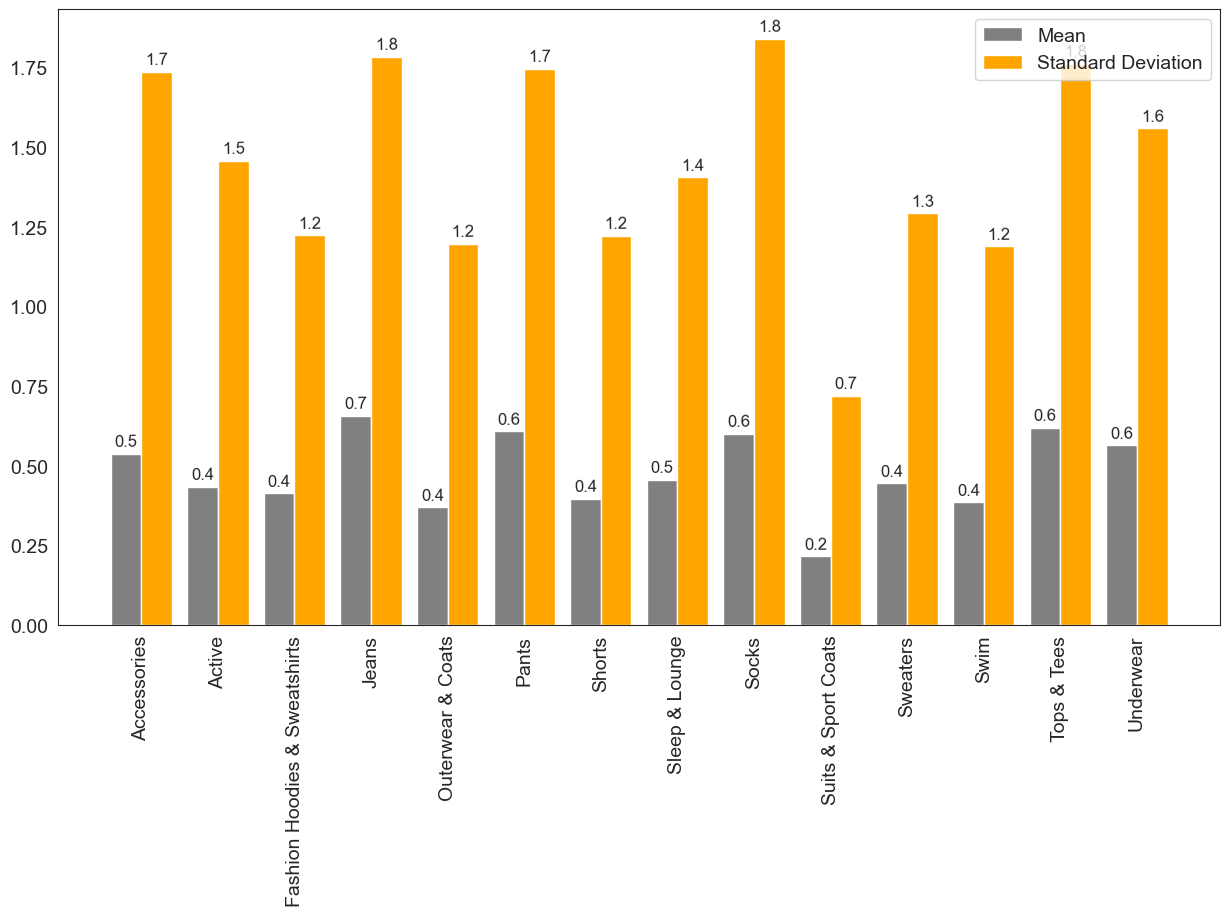

In [60]:
side_by_side_bar(cust_cat_matrix_male, mode='stats', annotation_rotation=1)

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">
    
## 📊 Summary of Category Means & Standard Deviations – Male Customers Only

This analysis explores **male-specific purchasing behavior** across product categories, using the **mean purchase frequency** and **standard deviation** per category. The goal is to uncover latent patterns and inform robust modeling strategies in a sparse environment.

---

### 🔍 Modeling Insights for the Male Customer × Category Matrix

#### 🧩 Persistent Sparsity Challenge

- **Estimated sparsity ≈ 87%**:
  - Most male customers purchase from **only a few categories**.
  - Despite being slightly denser than general customer matrices, **non-purchases still dominate** the dataset.

> ✔️ **Implication**: Models must retain zero values (non-purchases) as they represent meaningful consumer silence.

---

### 📈 Statistical Patterns

#### 🔢 Moderate Means with High Variability

- **Mean purchase values range from 0.2 to 0.65**, showing that:
  - Some categories (e.g., **Jeans**, **Tops & Tees**, **Pants**) are more frequently purchased.
  - Others (e.g., **Suits & Sport Coats**) have lower engagement.

📌 **Examples**:
- `Jeans` → **mean = 0.657**, **std = 1.785**
- `Socks` → **mean = 0.602**, **std = 1.841**
- `Tops & Tees` → **mean = 0.619**, **std = 1.762**

> 🧠 These high standard deviations relative to the means suggest **long-tail distributions**, where a **small group of customers makes multiple purchases**, while the **majority buys none**.

---

### 🧠 Implications for Modeling

#### 🚫 Importance of Zero-Preservation

- Non-purchases are not noise — they **encode absence of interest** or **product irrelevance**.
- Techniques like **Non-negative Matrix Factorization (NMF)** **retain zeros**, enabling more **accurate segmentation** based on latent interests.

#### ⚖️ Recommended Scaling Strategy

- ✅ **Use `RobustScaler(with_centering=False)`**

Why?

| Feature                          | Benefit                                                   |
|----------------------------------|------------------------------------------------------------|
| ✅ IQR-based scaling             | Reduces outlier impact (heavy buyers)                     |
| ✅ Non-negative output           | Keeps data compatible with NMF                            |
| ✅ Zero preservation             | Essential for sparse matrix modeling                      |
| ✅ No centering (mean subtraction) | Avoids negative values and preserves interpretability     |

> 🔁 Focuses model training on **typical customer behavior**, not statistical extremes.

---

### 🚀 Next Steps

- **Preprocess the matrix**:
  - Apply `RobustScaler(with_centering=False)` to male × category matrix.
- **Run NMF**:
  - Use NMF to identify latent male shopping segments.
  
📌 **Expected Segments** (examples):
- **Essentials-Only Buyers** → High on `Socks`, `Underwear`, `Tops & Tees`
- **Style-Conscious Buyers** → Focused on `Jeans`, `Fashion Hoodies`, `Accessories`
- **Occasional/Formal Shoppers** → Peaks in `Suits & Sport Coats`, `Outerwear`

---

### ✅ Summary

- The combination of **low-to-moderate means** and **high standard deviations** confirms that the data is **sparse** and **skewed**.
- **Robust preprocessing + NMF** leads to:
  - Statistically valid patterns
  - Real-world segment definitions
  - Actionable insights for **male-focused marketing strategies**


<br>

- **Standardize and scale matrix with RobustScaler.**

In [61]:
scaler = RobustScaler(with_centering=False)

X_male_robust = scaler.fit_transform(cust_cat_matrix_male)

X_male_robust

array([[0., 1., 0., ..., 2., 0., 0.],
       [0., 0., 0., ..., 0., 5., 0.],
       [0., 0., 0., ..., 0., 0., 8.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [6., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 4., 0.]])

<br>

- **Determining the Optimal Number of Components.**

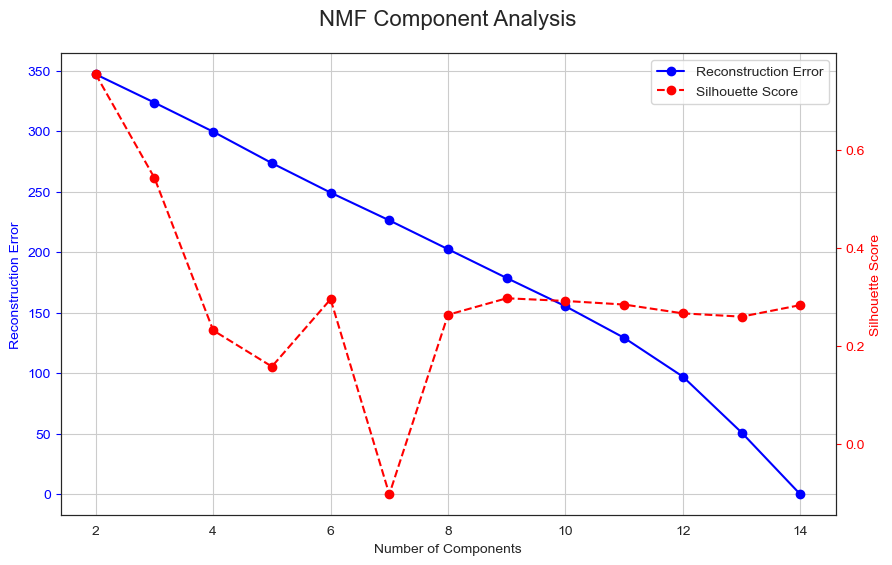

In [62]:
elbow_components(X_male_robust, range_max=15)

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">

### 🔍 Analysis and Recommendations for Male Segmentation

#### 📌 Key Observations

1. **Reconstruction Error Curve**  
   - The error decreases steadily from **k=2** to **k=6**, then the rate of improvement noticeably slows after **k=6**.

2. **Silhouette Score**  
   - **k = 6:** Silhouette ≈ **0.2950** (positive and relatively strong cohesion)  
   - **k = 7:** Silhouette ≈ **–0.1033** (negative, indicating poor cluster consistency)

3. **Reconciling the Metrics**  
   - **k = 2** delivers the highest Silhouette (≈ 0.75) but yields only two broad segments—likely too simplistic.  
   - **k = 6** strikes the best balance, aligning the “elbow” in reconstruction error with a solid Silhouette (≈ 0.295), suggesting stable and meaningful segmentation.  
   - **k = 5** has a lower Silhouette (≈ 0.1575) despite slightly better error reduction, making it less preferable compared to **k = 6**.

---

#### 🎯 Practical Recommendation

- **Primary Choice: k = 6**  
  - Captures the optimal elbow in the error curve.  
  - Maintains a positive and acceptable Silhouette (> 0.29), indicating good internal consistency.  
  - Reveals multiple, distinct male purchasing patterns—ideal for targeted campaigns and personalized recommendations.

- **Alternative: k = 2**  
  - Use if you need a **quick, binary segmentation** with maximum separation (Silhouette ≈ 0.75).

---

#### 🔑 Final Conclusion

Choosing **k = 6** enables a nuanced segmentation of your male customers into six clearly defined groups—balancing accuracy, stability, and business interpretability for marketing and recommendation strategies.  


<br>

- **Convert the scaled array back to a data frame.**

In [63]:
X_male_scaled_df = pd.DataFrame(X_male_robust, index=cust_cat_matrix_male.index, columns=cust_cat_matrix_male.columns)

X_male_scaled_df

category,Accessories,Active,Fashion Hoodies & Sweatshirts,Jeans,Outerwear & Coats,Pants,Shorts,Sleep & Lounge,Socks,Suits & Sport Coats,Sweaters,Swim,Tops & Tees,Underwear
customer_id,,,,,,,,,,,,,,
3,0.0,1.0,0.0,5.0,0.0,6.0,0.0,5.0,0.0,0.0,0.0,2.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
61,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,4.0,0.0
99939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
99951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


<br>

- **Applying the 6-component NMF algorithm to our scaled data matrix.**

In [64]:
W_male, H_male, segment_W_male_df, segment_H_male_df = NMF_Model(X_male_scaled_df, 6, 'nndsvda')

print(W_male)
print("\n", W_male.shape)

[[3.03211546e-002 8.66874300e-309 3.17248874e-001 3.85506339e-001
  6.34840056e-175 2.34261561e-001]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 9.63765848e-002
  3.73116787e-001 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 3.74818498e-001]
 ...
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 9.37046246e-002]
 [1.81926928e-001 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.92753170e-001
  2.98493430e-001 0.00000000e+000]]

 (4922, 6)


In [65]:
print(H_male)
print("\n", H_male.shape)

[[1.82534934e+01 1.47267808e+01 0.00000000e+00 0.00000000e+00
  1.23619468e-13 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.22486216e-14 1.85462509e-07 9.90346340e-13
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.77879804e-14 0.00000000e+00 8.10969106e-16 0.00000000e+00
  9.08682352e+00 3.27751688e+00 3.78818608e-12 4.37124951e-15
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.82259549e+00
  4.30753247e-16 0.00000000e+00 5.93790173e+00 0.00000000e+00
  0.00000000e+00 5.57505604e-15 7.09735920e-13 3.62680566e-12
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.24492435e+00 6.97629916e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.34524039e-08 5.10648326e+00 4.42422174e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.36868170e+00 0.00000000e+00
  1.51110946e-13 0.00000000e+00 0.00000000e+00 0.00000000e+00


In [66]:
segment_W_male_df.head()

,Pattern_1,Pattern_2,Pattern_3,Pattern_4,Pattern_5,Pattern_6
customer_id,,,,,,
3,3.032115e-02,8.668743e-309,3.172489e-01,0.385506,6.348401e-175,2.342616e-01
18,0.000000e+00,0.000000e+00,0.000000e+00,0.096377,3.731168e-01,0.000000e+00
20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,3.748185e-01
61,2.633207e-276,4.043887e-01,4.753406e-319,0.144565,9.710624e-267,2.597888e-240
75,0.000000e+00,8.087775e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00


In [67]:
segment_H_male_df

category,Accessories,Active,Fashion Hoodies & Sweatshirts,Jeans,Outerwear & Coats,Pants,Shorts,Sleep & Lounge,Socks,Suits & Sport Coats,Sweaters,Swim,Tops & Tees,Underwear
Pattern_1,18.253493,14.726781,0.000000,0.000000,1.236195e-13,0.000000,0.000000e+00,0.000000,0.000000,1.224862e-14,1.854625e-07,9.903463e-13,0.000000,0.000000
Pattern_2,0.000000,0.000000,0.000000,0.000000,1.778798e-14,0.000000,8.109691e-16,0.000000,9.086824,3.277517e+00,3.788186e-12,4.371250e-15,0.000000,0.000000
Pattern_3,0.000000,0.000000,0.000000,9.822595,4.307532e-16,0.000000,5.937902e+00,0.000000,0.000000,5.575056e-15,7.097359e-13,3.626806e-12,0.000000,0.000000
Pattern_4,0.000000,0.000000,0.000000,0.000000,4.244924e+00,6.976299,0.000000e+00,0.000000,0.000000,1.345240e-08,5.106483e+00,4.424222e+00,0.000000,0.000000
Pattern_5,0.000000,0.000000,5.368682,0.000000,1.511109e-13,0.000000,0.000000e+00,0.000000,0.000000,6.090727e-16,9.284231e-10,2.337735e-08,8.031948,0.000000
Pattern_6,0.000000,0.000000,0.000000,0.000000,5.044386e-12,0.000000,0.000000e+00,9.542223,0.000000,3.152549e-15,0.000000e+00,3.595970e-13,0.000000,11.801441


<br>

- **Allocate the segment based on the highest weight for each customer.**

In [68]:
segment_category_male_nmf = Segment_Category_NMF(cust_cat_matrix_male, W_male)

segment_category_male_nmf

category,Accessories,Active,Fashion Hoodies & Sweatshirts,Jeans,Outerwear & Coats,Pants,Shorts,Sleep & Lounge,Socks,Suits & Sport Coats,Sweaters,Swim,Tops & Tees,Underwear,segment
customer_id,,,,,,,,,,,,,,,
3,0.0,1.0,0.0,5.0,0.0,6.0,0.0,5.0,0.0,0.0,0.0,2.0,0.0,0.0,4
18,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,6
61,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2
75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,4.0,0.0,2
99939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2
99951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,6


<br>

- **Show a heat map of the male segment centers for each category.**

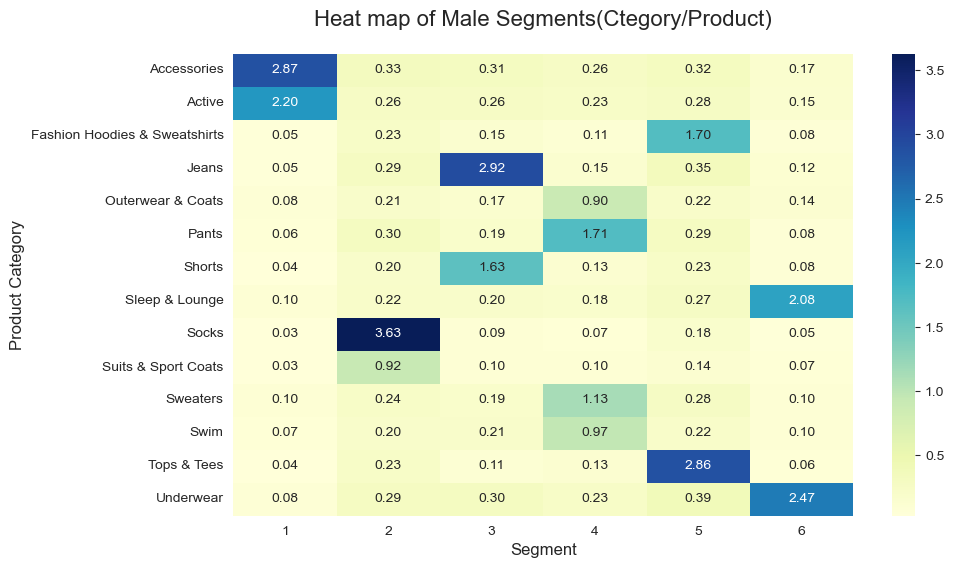

In [69]:
nmf_male_average = heat_map_segments(segment_category_male_nmf, "Heat map of Male Segments(Ctegory/Product)")

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">
    
### 🧩 Segment-Level Insights: Male Customers by Product Category

Based on the average category weights across the **six customer segments**—generated via **NMF (Non-negative Matrix Factorization)** applied to the **Male Customers × Original Categories** matrix—we can derive the following strategic insights:

---

#### 🔹 Segment 1
**Top Categories:**
- Accessories (**2.87**)
- Active (**2.20**)

**🧠 Insight:**  
This group shows a strong inclination toward **accessories** (e.g., belts, bags, hats) and **activewear**.

**🎯 Recommendation:**  
Target with **cross-sell offers** combining accessories with sporty items (e.g., sneakers, gym bags). Think “on-the-go essentials.”

---

#### 🔹 Segment 2
**Top Categories:**
- Socks (**3.63**)
- Suits & Sport Coats (**0.92**)
- Underwear (**0.29**)

**🧠 Insight:**  
These customers focus heavily on **essentials**, particularly socks and underwear, with some interest in formal attire.

**🎯 Recommendation:**  
Launch **bundle deals** on socks and underwear or promote “stock-up and save” campaigns for **wardrobe basics**.

---

#### 🔹 Segment 3
**Top Categories:**
- Jeans (**2.92**)
- Shorts (**1.63**)

**🧠 Insight:**  
Casual dressers with a preference for **denim** and **seasonal lower-body wear**.

**🎯 Recommendation:**  
Market **casual collections** like jeans, shorts, and “weekend-ready” looks. Ideal for **seasonal refresh** campaigns.

---

#### 🔹 Segment 4
**Top Categories:**
- Pants (**1.71**)
- Sweaters (**1.13**)
- Swim (**0.97**)
- Outerwear & Coats (**0.90**)

**🧠 Insight:**  
This group blends **daily formal wear** with **seasonal items** (winter/summer outerwear).

**🎯 Recommendation:**  
Curate **seasonal outfits**, such as **fall/winter essentials** or **vacation-ready selections**.

---

#### 🔹 Segment 5
**Top Categories:**
- Tops & Tees (**2.86**)
- Fashion Hoodies & Sweatshirts (**1.70**)

**🧠 Insight:**  
Trend-aware and likely **younger**, this group favors **casual streetwear** styles.

**🎯 Recommendation:**  
Push **urban fashion drops**, streetwear collections, or **limited-edition collaborations**.

---

#### 🔹 Segment 6
**Top Categories:**
- Underwear (**2.47**)
- Sleep & Lounge (**2.08**)

**🧠 Insight:**  
Strong focus on **comfort-oriented** pieces like sleepwear and undergarments.

**🎯 Recommendation:**  
Run **“Home Comfort” promotions** bundling loungewear and underwear—perfect for stay-at-home or relaxation themes.

---

### ✅ Overall Conclusions

- **Clear Diversity:**  
  Male customer behavior varies significantly across segments, reflecting distinct lifestyle preferences.

- **High Interpretability:**  
  Segments are easy to understand and translate into **targeted marketing actions**.

- **Marketing Potential:**  
  This segmentation supports **personalized campaigns**, increases **conversion rates**, and helps **optimize product positioning**.

This NMF-based approach effectively captures **real behavioral patterns** and offers a **solid foundation** for data-driven marketing and recommendation strategies.


<br>

- **Extract demographic information.**

In [70]:
customer_info_male = df[df['gender'] == 'M'][["customer_id","age", "region"]].groupby("customer_id").max().reset_index()

customer_info_male

,customer_id,age,region
0,3,16,South
1,18,17,West
2,20,13,South
3,61,69,West
4,75,22,Northeast
...,...,...,...
4917,99914,46,West
4918,99939,66,West
4919,99951,25,South
4920,99985,45,West


<br>

- **concating demographic information with W results.**

In [71]:
Demographic_segment_male = pd.concat([customer_info_male.reset_index(drop=True), 
                                      segment_category_male_nmf.reset_index(drop=True)], axis=1)

Demographic_segment_male

,customer_id,age,region,Accessories,Active,Fashion Hoodies & Sweatshirts,Jeans,Outerwear & Coats,Pants,Shorts,Sleep & Lounge,Socks,Suits & Sport Coats,Sweaters,Swim,Tops & Tees,Underwear,segment
0,3,16,South,0.0,1.0,0.0,5.0,0.0,6.0,0.0,5.0,0.0,0.0,0.0,2.0,0.0,0.0,4
1,18,17,West,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5
2,20,13,South,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,6
3,61,69,West,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2
4,75,22,Northeast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4917,99914,46,West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,4.0,0.0,2
4918,99939,66,West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2
4919,99951,25,South,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,6
4920,99985,45,West,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [72]:
Demographic_segment_male.to_csv("Demographic_segment_male.csv", index=False)

 <br>

- **Show the number of male customers per segment.**

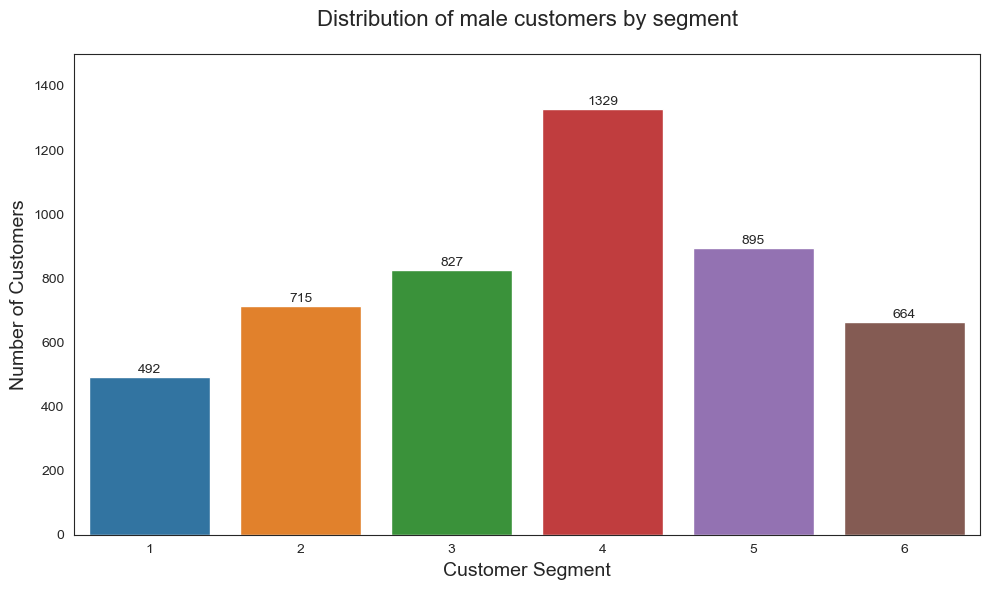

In [73]:
cust_segment_countplot(Demographic_segment_male, 'Distribution of male customers by segment', 1500)

<br>

- **Show male age distribution for each segment.**

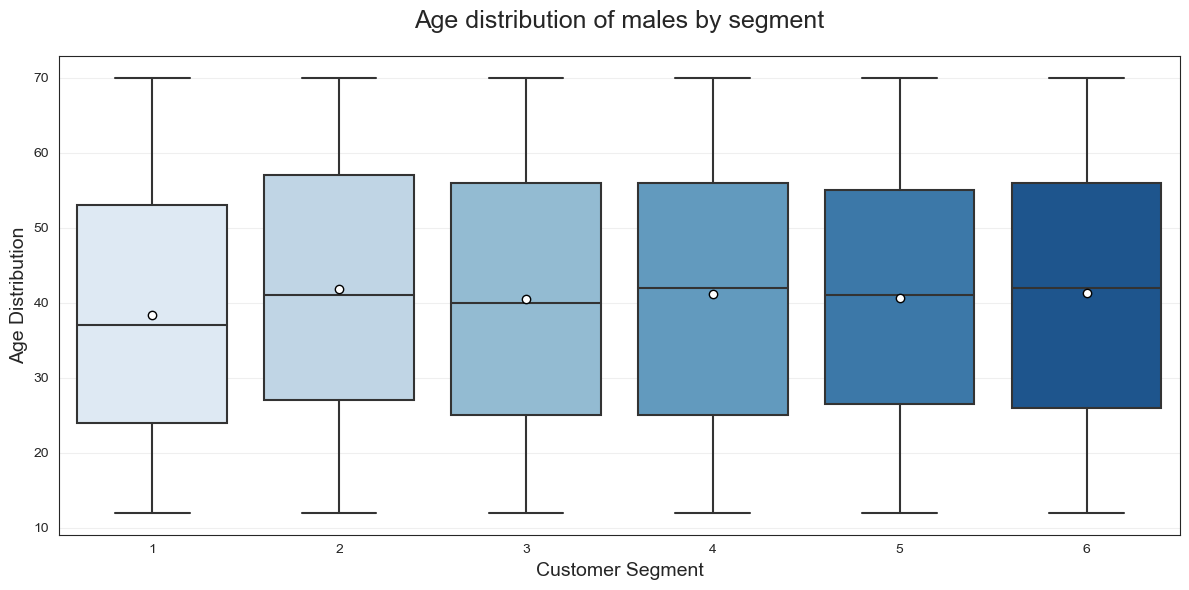

In [74]:
cust_segment_age_boxplot(Demographic_segment_male, 'Age distribution of males by segment')

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">
    
### 👤 Demographic Summary of Male Segments (Age & Region)

This analysis presents key demographic characteristics for each of the six male customer segments—based on their **average age**, **dominant region**, and **segment size**. These insights are critical for designing tailored campaigns and evaluating potential regional or age-related gaps.

---

### 🔍 Key Insights

#### 1️⃣ Consistent Age Range
All segments fall within a **narrow age band of 38–42 years**, indicating a **predominantly middle-aged** male customer base.

- **Implication:** No strong generational divisions, allowing for streamlined campaign messaging across age groups.

---

#### 2️⃣ Geographic Concentration
Every segment’s **top region** is the **South**.

- **Implication:** Either the dataset is skewed toward the Southern region or the South genuinely constitutes the core of your male customer base.

- **Action:**  
  - Double down on **regional campaigns in the South**.
  - If broader geographic reach is desired, consider **collecting more balanced data** across other regions.

---

#### 3️⃣ Segment Sizes & Business Impact

| Segment | Top Categories              | Avg Age | Top Region | Size  |
|---------|-----------------------------|---------|-------------|-------|
| 1       | Accessories, Active         | 38.3    | South       | 492   |
| 2       | Socks, Suits & Sport Coats  | 41.9    | South       | 677   |
| 3       | Jeans, Shorts               | 40.5    | South       | 505   |
| 4       | Pants, Sweaters             | 41.2    | South       | 1,329 |
| 5       | Tops & Tees, Hoodies        | 40.7    | South       | 688   |
| 6       | Underwear, Sleep & Lounge   | 41.3    | South       | 1,007 |

- **Segment 4** is the **largest group** and represents a strong market for versatile daily wear.
- **Segment 1** is the **smallest** but may include **high-margin buyers** interested in accessories and activewear.

---

#### 4️⃣ Tailored Marketing Opportunities

- **Segment 1** (Avg Age 38.3): Fitness & lifestyle bundles—e.g., **gym bags + accessories**.
- **Segment 2** (Avg Age 41.9): Basics + formals—**"upgrade your essentials"** promotions.
- **Segment 3 & 5** (Avg Ages ~40.5–40.7): Casual fashion lovers—launch **seasonal denim collections** and **streetwear drops**.
- **Segment 4** (Avg Age 41.2): Largest audience—use **broad “Build Your Wardrobe” campaigns** with pants and sweaters.
- **Segment 6** (Avg Age 41.3): Comfort-focused buyers—**"Cozy Nights" promotions** with sleepwear and underwear.

---

#### 5️⃣ Action Plan

✅ **Focus on the South:**  
  Regional targeting in the South is likely to yield the highest return.

✅ **Segment-Specific Messaging:**  
  Highlight top categories for each group in your email content, ads, and landing pages.

✅ **Test & Optimize:**  
  Run **A/B tests** on campaign types (e.g., accessory bundles vs. discounts) within each segment.

✅ **Explore New Regions:**  
  If geographic expansion is strategic, replicate this segmentation method for **non-Southern markets** and compare behavioral patterns.

---


<a id="Female"></a>
# <div style="padding:20px;color:white;margin:0;font-size:25px;font-family:Georgia;text-align:center;display:fill;border-radius:30px;background-color:#404040;overflow:hidden"><b>2. Segmentation by Female</b></div>

- **Filter the dataset to females only.**

In [75]:
df_female = df[df['gender'] == 'F']

df_female.head()

,order_item_id,invoice_no,product_id,product_description,category,brand,department,transaction_date,cost,shipping_cost_1000_mile,unit_price,quantity,sales,customer_id,age,gender,postal_code,city,state,state_ab,region,customer_latitude,customer_longitude,state_latitude,state_longitude,category_merged
0,142771,98298,13928,Low Profile Dyed Cotton Twill Cap - Putty W39S55D,Accessories,MG,Women,2023-11-19 09:52:00+00:00,2.34,0.19,5.95,4,23.80,78444,39,F,38655,Oxford,Mississippi,MS,South,34.329453,-89.468527,32.741646,-89.678696,Accessories
1,142772,98298,5803,LOCOMO Women Patriot Patriotic Great Britain B...,Leggings,LOCOMO Leggings,Women,2023-11-19 09:52:00+00:00,8.74,0.81,14.99,3,44.97,78444,39,F,38655,Oxford,Mississippi,MS,South,34.329453,-89.468527,32.741646,-89.678696,Leggings
2,142774,98298,10182,Floral Flannel Pajamas - Misses Sizes,Sleep & Lounge,Carol Wright Gifts,Women,2023-11-19 09:52:00+00:00,10.08,0.82,16.99,2,33.98,78444,39,F,38655,Oxford,Mississippi,MS,South,34.329453,-89.468527,32.741646,-89.678696,Sleep & Lounge
3,142776,98299,12882,Speedo Women's Color Block Zip Front Endurance...,Swim,Speedo,Women,2023-11-30 09:52:00+00:00,35.04,3.26,79.99,5,399.95,78444,39,F,38655,Oxford,Mississippi,MS,South,34.329453,-89.468527,32.741646,-89.678696,Swim
4,142775,98299,15918,Glamorise Women's Soft Shoulders Minimizer Bra...,Plus,Glamorise,Women,2023-11-30 09:52:00+00:00,22.81,1.97,45.99,4,183.96,78444,39,F,38655,Oxford,Mississippi,MS,South,34.329453,-89.468527,32.741646,-89.678696,Plus


<br>

- **Create a sparse matrix with `customer_id` x `category`.**

In [76]:
cust_cat_matrix_female = df_female.pivot_table(index="customer_id", 
                                 columns="category", 
                                 values="quantity", 
                                 aggfunc="sum", 
                                 )

cust_cat_matrix_female.head()

category,Accessories,Active,Blazers & Jackets,Clothing Sets,Dresses,Fashion Hoodies & Sweatshirts,Intimates,Jeans,Jumpsuits & Rompers,Leggings,Maternity,Outerwear & Coats,Pants & Capris,Plus,Shorts,Skirts,Sleep & Lounge,Socks & Hosiery,Suits,Sweaters,Swim,Tops & Tees
customer_id,,,,,,,,,,,,,,,,,,,,,,
30,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN
94,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,4.0,NaN,NaN,NaN,7.0,NaN,NaN,NaN,8.0,NaN,1.0,NaN,NaN
104,2.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
cust_cat_matrix_female.shape

(4971, 22)

<br>

- **Calculating data sparsity.**

In [78]:
print("sparsity rate is:", round(Sparsity_Rate(cust_cat_matrix_female), 10))

sparsity rate is: 0.9178416635


<br>

- **Fill the empty values in the matrix with the value zero.**

In [79]:
cust_cat_matrix_female.fillna(0, inplace=True)

cust_cat_matrix_female.head()

category,Accessories,Active,Blazers & Jackets,Clothing Sets,Dresses,Fashion Hoodies & Sweatshirts,Intimates,Jeans,Jumpsuits & Rompers,Leggings,Maternity,Outerwear & Coats,Pants & Capris,Plus,Shorts,Skirts,Sleep & Lounge,Socks & Hosiery,Suits,Sweaters,Swim,Tops & Tees
customer_id,,,,,,,,,,,,,,,,,,,,,,
30,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
94,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,4.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0
104,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<br>

- **Show descriptive matrix summaries.**

In [80]:
cust_cat_matrix_female.agg(['sum', 'mean', 'std', 'max']).round(2).T.sort_values(by="sum")

,sum,mean,std,max
category,,,,
Clothing Sets,57.0,0.01,0.20,5.0
Suits,241.0,0.05,0.34,5.0
Jumpsuits & Rompers,282.0,0.06,0.46,10.0
Skirts,595.0,0.12,0.67,10.0
Blazers & Jackets,642.0,0.13,0.55,6.0
Pants & Capris,983.0,0.20,0.83,6.0
Outerwear & Coats,1053.0,0.21,0.86,10.0
Leggings,1125.0,0.23,0.90,9.0
Sweaters,1219.0,0.25,0.93,7.0


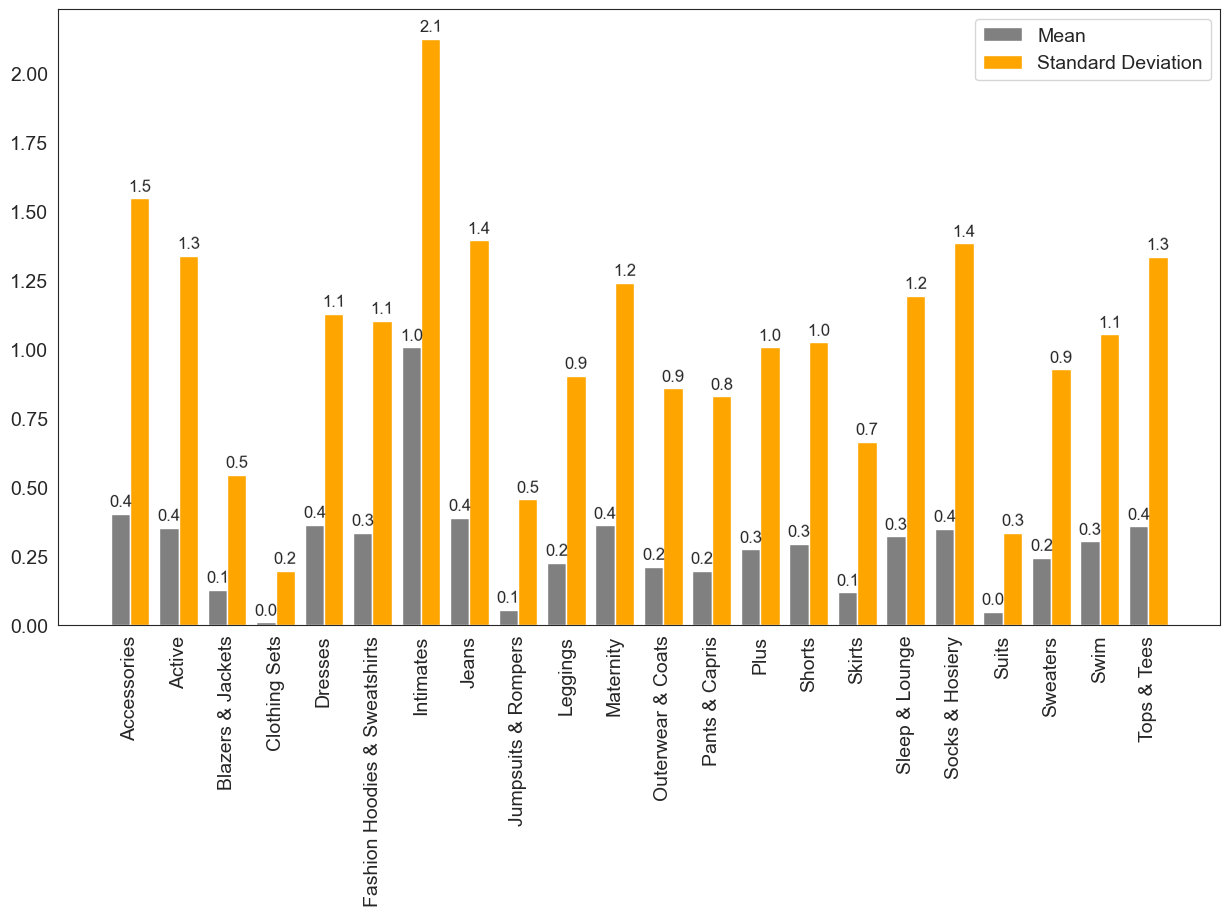

In [81]:
side_by_side_bar(cust_cat_matrix_female, mode='stats', annotation_rotation=1)

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">

## 📊 Summary of Category Means & Standard Deviations – Female Customers Only

This section provides a **statistical overview** of female customer purchasing behavior across product categories, using the **mean** and **standard deviation** of purchases per category. The findings are based on the female-specific customer-category matrix.

---

### 🔍 Key Observations

#### 🔢 Very Low Means
Across nearly all product categories, the **mean purchase frequency is well below 1.0**:
- ➤ Indicates that most female customers either **do not purchase at all (zeroes)** or buy **only one item per category**.
- This reflects a **highly sparse** dataset, common in retail analytics.

📌 **Examples:**
- **Suits:** Mean = 0.05
- **Clothing Sets:** Mean = 0.01
- **Jumpsuits & Rompers:** Mean = 0.06

---

#### 📈 High Relative Variance
In many categories, the **standard deviation is significantly higher than the mean**, indicating:
- A **long-tailed distribution**:
  - ➤ A **small segment** of customers make many purchases.
  - ➤ The **majority buy none or very few**.

📌 **Examples:**
- **Intimates:** Mean = 1.01, Std Dev = 2.13
- **Accessories:** Mean = 0.41, Std Dev = 1.55

---

### 🧺 Distinct Category Behavior

- **Intimates**:
  - 📈 **Highest mean and standard deviation**
  - ➤ Strong indicator of **frequent or repeated purchases** among female customers

- **Suits, Skirts, and Clothing Sets**:
  - 📉 **Lowest means and deviations**
  - ➤ Likely reflect **niche or occasional purchase behavior**

---

### 🧠 Implications for Modeling

#### 🚫 Importance of Zero-Preservation
- Non-purchases (zeros) **carry valuable behavioral signals**.
- ➤ Preserving them is essential for models like **NMF** to learn true category preferences and disinterest.

#### ⚖️ Robust Feature Scaling Strategy
- ✅ **Recommended Scaler**: `RobustScaler(with_centering=False)`
- ✔️ Why it works:
  - Reduces **outlier influence** (e.g., from bulk buyers)
  - Maintains **sparsity and non-negativity**
  - Uses **IQR (Interquartile Range)** for scaling:
    - IQR = 75th percentile – 25th percentile
    - ➤ Resilient to skewed data and long tails

---

### ✅ Summary

- The female customer matrix is **sparse**, **skewed**, and **long-tailed**.
- These characteristics strongly support:
  - ➤ Continued use of **RobustScaler** to preprocess features.
  - ➤ Application of **Non-negative Matrix Factorization (NMF)** to extract **interpretable, latent behavioral patterns**.



<br>

- **Standardize and scale matrix with RobustScaler.**

In [82]:
X_female_robust = scaler.fit_transform(cust_cat_matrix_female)

X_female_robust

array([[0., 0., 2., ..., 0., 0., 3.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 6., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<br>

- **Determining the Optimal Number of Components.**

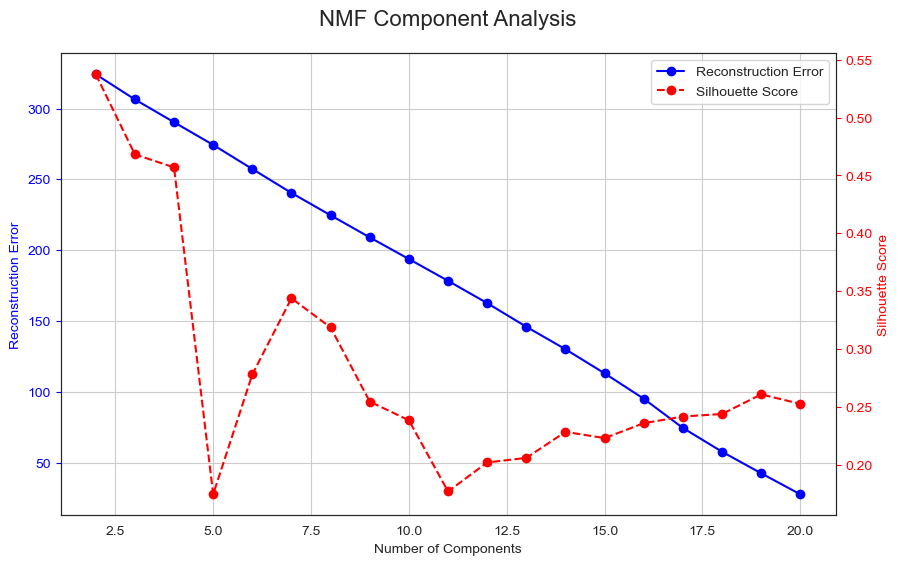

In [83]:
elbow_components(X_female_robust, 21)

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">


## 🔍 NMF Component Selection Analysis – Female Customers

After applying the **Elbow Method** and evaluating **Silhouette Scores** for NMF on the sparse matrix (female customers × original categories), the following observations were made:

---

### 📉 Reconstruction Error

The reconstruction error shows a smooth and consistent decrease as the number of components increases:

From 324 → 27 as components increase from 2 to 21


- This indicates that adding more components steadily improves the matrix approximation.
- However, the marginal gain begins to plateau around **component 10**.
- A noticeable elbow appears between **components 15 to 16**, which suggests an optimal range for model complexity.

✅ **Elbow Point Suggestion:** Around **15 or 16 components**

---

### 🧩 Silhouette Scores (Cluster Cohesion & Separation)

Silhouette scores were evaluated after projecting the matrix into NMF space and applying clustering:

| Components | Silhouette Score |
|------------|------------------|
| 2          | **0.537** (highest) |
| 3          | 0.468 |
| 4          | 0.457 |
| 5          | 0.175 |
| 6          | 0.278 |
| 7          | **0.344** (notable) |
| 8–13       | Range: 0.17 – 0.23 |
| 14–18      | Range: 0.23 – 0.26 |
| 19–21      | Around 0.25 |

- The highest score occurs at **2 components**, which is expected but likely oversimplifies the segments.
- Scores stabilize between **0.24–0.26** from **components 15 to 18**, suggesting decent clustering quality.

---

### ✅ Summary & Recommendation

| Aspect                     | Insight |
|----------------------------|---------|
| Best reduction in error    | Components **10 to 16** |
| Best (but oversimplified) silhouette | Component **2** |
| Best trade-off (balanced detail & cohesion) | **7–10** is reasonable, **15–17** is strong |

**Recommendation:**  
Based on the above, we choose **k=8** because it reveals multiple patterns with acceptable internal consistency of the segments, and it will be useful for personalized campaigns and accurate recommendations.



<br>

- **Convert the scaled array back to a data frame.**

In [84]:
X_female_scaled_df = pd.DataFrame(X_female_robust,
                                  index=cust_cat_matrix_female.index,
                                  columns=cust_cat_matrix_female.columns)

X_female_scaled_df

category,Accessories,Active,Blazers & Jackets,Clothing Sets,Dresses,Fashion Hoodies & Sweatshirts,Intimates,Jeans,Jumpsuits & Rompers,Leggings,Maternity,Outerwear & Coats,Pants & Capris,Plus,Shorts,Skirts,Sleep & Lounge,Socks & Hosiery,Suits,Sweaters,Swim,Tops & Tees
customer_id,,,,,,,,,,,,,,,,,,,,,,
30,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
94,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,4.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0
104,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
99898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99912,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0


<br>

- **Applying the 7-component NMF algorithm to our scaled data matrix.**

In [85]:
W_female, H_female, segment_W_female_df, segment_H_female_df = NMF_Model(X_female_scaled_df, 8, 'nndsvda')

print(W_female)
print("\n", W_female.shape)

[[6.91104470e-223 1.12850923e-237 1.86509492e-268 ... 2.90052218e-001
  2.13687988e-001 3.00566524e-284]
 [1.07816153e-308 1.00528938e-296 0.00000000e+000 ... 3.89477398e-272
  8.54751952e-002 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 ...
 [2.48041211e-296 2.09386942e-237 1.05307425e-272 ... 1.73939853e-282
  2.07750644e-314 5.02532989e-001]
 [3.35839323e-002 4.17654027e-002 1.22845053e-249 ... 4.31412839e-260
  4.18977254e-250 1.67510996e-001]
 [2.01503594e-001 6.62437822e-268 7.42547881e-293 ... 1.15846507e-309
  1.28212793e-001 2.69156600e-272]]

 (4971, 8)


In [86]:
print(H_female)
print("\n", H_female.shape)

[[0.00000000e+00 0.00000000e+00 7.52221891e-15 0.00000000e+00
  1.03092350e-12 0.00000000e+00 2.97761439e+01 0.00000000e+00
  7.06750860e-16 2.05938708e-14 0.00000000e+00 1.48105927e-10
  0.00000000e+00 5.57358144e-11 4.46154075e-15 1.52875594e-11
  0.00000000e+00 0.00000000e+00 1.32833682e-13 9.52943907e-15
  0.00000000e+00 0.00000000e+00]
 [1.36615447e+01 0.00000000e+00 5.34542361e-12 3.51135480e-11
  3.91191291e-13 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.25455887e-15 2.17462577e-13 0.00000000e+00 1.42915900e-15
  3.28905220e-15 1.90260022e-13 8.18658702e-14 6.76969158e-12
  0.00000000e+00 0.00000000e+00 0.00000000e+00 6.31594071e-16
  1.02817178e+01 0.00000000e+00]
 [0.00000000e+00 2.82248722e-16 6.67081169e-14 0.00000000e+00
  1.60690140e-14 0.00000000e+00 0.00000000e+00 1.73901933e+01
  0.00000000e+00 3.79481908e-11 0.00000000e+00 0.00000000e+00
  4.16983962e-15 7.12979729e-14 1.16700662e-12 2.08071571e-15
  0.00000000e+00 0.00000000e+00 4.60299626e-13 1.43967242e-12
  0.

In [87]:
segment_W_female_df.head()

,Pattern_1,Pattern_2,Pattern_3,Pattern_4,Pattern_5,Pattern_6,Pattern_7,Pattern_8
customer_id,,,,,,,,
30,6.911045e-223,1.128509e-237,1.865095e-268,1.294413e-01,2.068929e-01,2.900522e-01,2.136880e-01,3.005665e-284
37,1.078162e-308,1.005289e-296,0.000000e+00,4.514378e-262,5.811775e-244,3.894774e-272,8.547520e-02,0.000000e+00
42,0.000000e+00,0.000000e+00,0.000000e+00,5.177652e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
94,2.015036e-01,1.503538e-269,6.485221e-229,5.177652e-01,1.235389e-279,6.961253e-01,2.160747e-255,1.213547e-262
104,3.526963e-215,8.353081e-02,9.900638e-293,1.294413e-01,4.327405e-305,1.544620e-309,1.709504e-01,1.613620e-230


In [88]:
segment_H_female_df

category,Accessories,Active,Blazers & Jackets,Clothing Sets,Dresses,Fashion Hoodies & Sweatshirts,Intimates,Jeans,Jumpsuits & Rompers,Leggings,Maternity,Outerwear & Coats,Pants & Capris,Plus,Shorts,Skirts,Sleep & Lounge,Socks & Hosiery,Suits,Sweaters,Swim,Tops & Tees
Pattern_1,0.000000,0.000000e+00,7.522219e-15,0.000000e+00,1.030923e-12,0.000000e+00,29.776144,0.000000,7.067509e-16,2.059387e-14,0.000000,1.481059e-10,0.000000e+00,5.573581e-11,4.461541e-15,1.528756e-11,0.000000,0.000000,1.328337e-13,9.529439e-15,0.000000,0.000000
Pattern_2,13.661545,0.000000e+00,5.345424e-12,3.511355e-11,3.911913e-13,0.000000e+00,0.000000,0.000000,2.254559e-15,2.174626e-13,0.000000,1.429159e-15,3.289052e-15,1.902600e-13,8.186587e-14,6.769692e-12,0.000000,0.000000,0.000000e+00,6.315941e-16,10.281718,0.000000
Pattern_3,0.000000,2.822487e-16,6.670812e-14,0.000000e+00,1.606901e-14,0.000000e+00,0.000000,17.390193,0.000000e+00,3.794819e-11,0.000000,0.000000e+00,4.169840e-15,7.129797e-14,1.167007e-12,2.080716e-15,0.000000,0.000000,4.602996e-13,1.439672e-12,0.000000,0.000000
Pattern_4,0.000000,0.000000e+00,2.244751e+00,0.000000e+00,1.789803e-15,0.000000e+00,0.000000,0.000000,7.860510e-14,2.651718e-15,0.000000,3.681811e+00,3.437056e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,6.087401,6.239473e-10,1.130392e-15,0.000000,0.000000
Pattern_5,0.000000,0.000000e+00,1.242096e-14,0.000000e+00,3.229154e-15,0.000000e+00,0.000000,0.000000,5.934100e-13,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.103966e-15,0.000000e+00,6.069680e-14,0.000000,0.000000,0.000000e+00,3.968704e-13,0.000000,14.500259
Pattern_6,0.000000,4.995860e+00,2.144199e-14,0.000000e+00,2.300576e-15,0.000000e+00,0.000000,0.000000,2.752844e-14,3.197010e+00,0.000000,0.000000e+00,0.000000e+00,3.890405e+00,0.000000e+00,1.690863e+00,0.000000,0.000000,1.369326e-13,3.464137e+00,0.000000,0.000000
Pattern_7,0.000000,0.000000e+00,7.375956e-16,0.000000e+00,7.883790e+00,1.500856e-15,0.000000,0.000000,1.228982e+00,0.000000e+00,7.857642,0.000000e+00,0.000000e+00,1.665899e-12,6.428187e+00,0.000000e+00,0.000000,0.000000,5.869049e-13,2.350466e-13,0.000000,0.000000
Pattern_8,0.000000,0.000000e+00,1.761669e-14,2.860265e-01,1.764927e-13,8.370038e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,1.518295e-11,0.000000e+00,2.340034e-15,1.469230e-13,1.059233e-15,8.043867,0.000000,1.209340e+00,3.512605e-12,0.000000,0.000000


<br>

- **Allocate the segment based on the highest weight for each customer.**

In [89]:
segment_category_female_nmf = Segment_Category_NMF(cust_cat_matrix_female, W_female)

segment_category_female_nmf

category,Accessories,Active,Blazers & Jackets,Clothing Sets,Dresses,Fashion Hoodies & Sweatshirts,Intimates,Jeans,Jumpsuits & Rompers,Leggings,Maternity,Outerwear & Coats,Pants & Capris,Plus,Shorts,Skirts,Sleep & Lounge,Socks & Hosiery,Suits,Sweaters,Swim,Tops & Tees,segment
customer_id,,,,,,,,,,,,,,,,,,,,,,,
30,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,6
37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,4
94,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,4.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0,6
104,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2
99898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
99912,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,8


<br>

- **Show a heat map of the female segment centers for each category.**

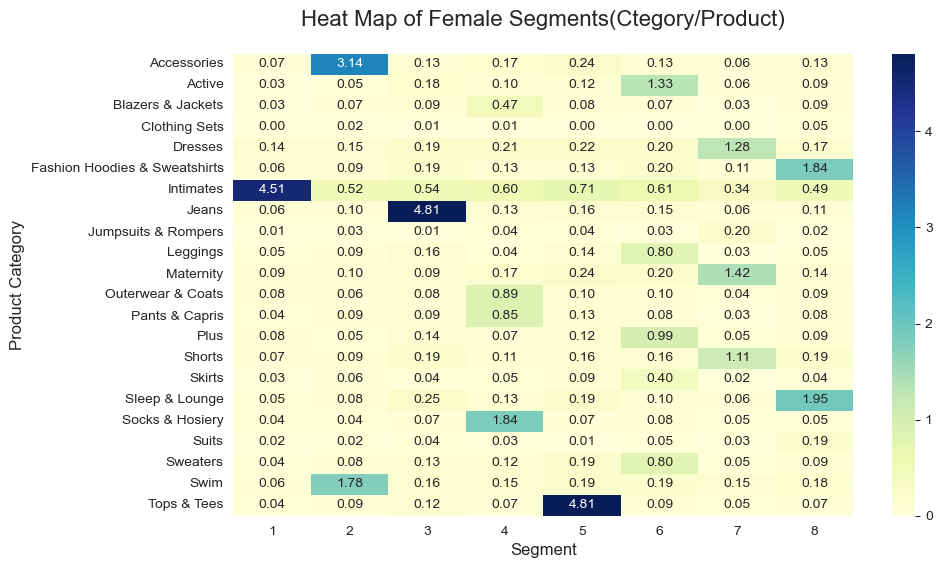

In [90]:
nmf_female_average = heat_map_segments(segment_category_female_nmf, "Heat Map of Female Segments(Ctegory/Product)")

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">
    

## 🔍 Analysis of NMF Segments for Female Customers

After applying **Non-negative Matrix Factorization (NMF)** with 8 components to the matrix of *female customers × original product categories*, and calculating the mean purchase values per segment, the following behavioral patterns emerged:

---

### ✅ Segment Interpretations

#### **Segment 1 — Intimates-Dominant**
- **Highest in**: `Intimates (4.51)`
- **Insight**: This group of customers shows a strong and exclusive preference for intimate apparel. Other categories are almost negligible.

---

#### **Segment 2 — Accessories & Swim-Focused**
- **Highest in**: `Accessories (3.14)`, `Swim (1.78)`
- **Insight**: These customers prefer accessories and swimwear, likely representing seasonal or leisure-oriented buyers.

---

#### **Segment 3 — Jeans-Loyal**
- **Highest in**: `Jeans (4.81)`
- **Insight**: Strong focus on jeans implies a casual or daily wear preference.

---

#### **Segment 4 — Outerwear & Essentials**
- **Highest in**: `Outerwear & Coats (0.89)`, `Pants & Capris (0.85)`, `Socks & Hosiery (1.84)`
- **Insight**: Likely represents a practical wardrobe with a mix of formal and basic essentials.

---

#### **Segment 5 — Tops & Tees-Centric**
- **Highest in**: `Tops & Tees (4.81)`
- **Insight**: Customers here exhibit a clear preference for basic and versatile clothing.

---

#### **Segment 6 — Activewear-Oriented**
- **Highest in**: `Active (1.33)`, `Leggings (0.80)`, `Sweaters (0.80)`
- **Insight**: Likely active or fitness-focused customers who favor flexible and sporty outfits.

---

#### **Segment 7 — Feminine Style & Maternity**
- **Highest in**: `Dresses (1.28)`, `Maternity (1.42)`, `Skirts (1.11)`
- **Insight**: This segment seems to reflect feminine or maternity fashion needs.

---

#### **Segment 8 — Comfort & Casual Fashion**
- **Highest in**: `Fashion Hoodies & Sweatshirts (1.84)`, `Sleep & Lounge (1.95)`
- **Insight**: These customers appear to favor comfort-focused homewear with a trendy twist.

---

### 📌 Summary Insight
- NMF successfully revealed **distinct purchasing behavior** among female customers.
- Some segments are highly focused on a single category, suggesting **clear targeting opportunities**.
- This analysis supports **personalized marketing strategies** and **product recommendation engines** based on latent user interests.



<br>

- **Extract demographic information.**

In [91]:
customer_info_female = df[df['gender'] == 'F'][["customer_id","age", "region"]].groupby("customer_id").max().reset_index()

customer_info_female

,customer_id,age,region
0,30,16,West
1,37,34,Northeast
2,42,31,South
3,94,17,South
4,104,28,West
...,...,...,...
4966,99873,14,Northeast
4967,99898,25,South
4968,99912,33,Midwest
4969,99923,25,West


<br>

- **concating demographic information with W results.**

In [92]:
Demographic_segment_female = pd.concat([customer_info_female.reset_index(drop=True), 
                                      segment_category_female_nmf.reset_index(drop=True)], axis=1)

Demographic_segment_female

,customer_id,age,region,Accessories,Active,Blazers & Jackets,Clothing Sets,Dresses,Fashion Hoodies & Sweatshirts,Intimates,Jeans,Jumpsuits & Rompers,Leggings,Maternity,Outerwear & Coats,Pants & Capris,Plus,Shorts,Skirts,Sleep & Lounge,Socks & Hosiery,Suits,Sweaters,Swim,Tops & Tees,segment
0,30,16,West,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,6
1,37,34,Northeast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
2,42,31,South,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,4
3,94,17,South,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,4.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0,6
4,104,28,West,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4966,99873,14,Northeast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2
4967,99898,25,South,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
4968,99912,33,Midwest,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,8
4969,99923,25,West,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,8


In [93]:
Demographic_segment_female.to_csv("Demographic_segment_female.csv", index=False)

 <br>

- **Show the number of female customers per segment.**

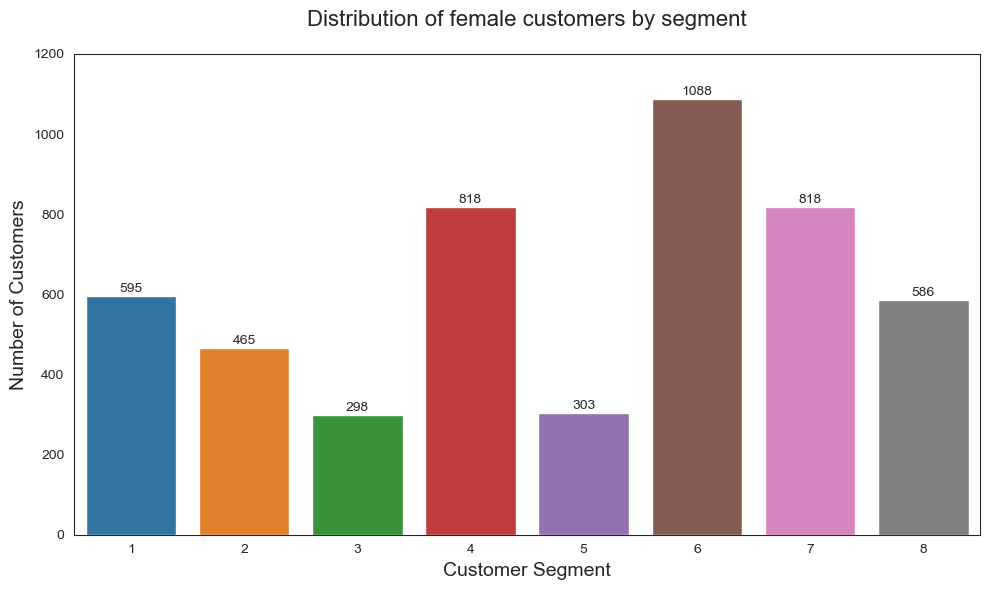

In [94]:
cust_segment_countplot(Demographic_segment_female, 'Distribution of female customers by segment', 1200)

<br>

- **Show female age distribution for each segment.**

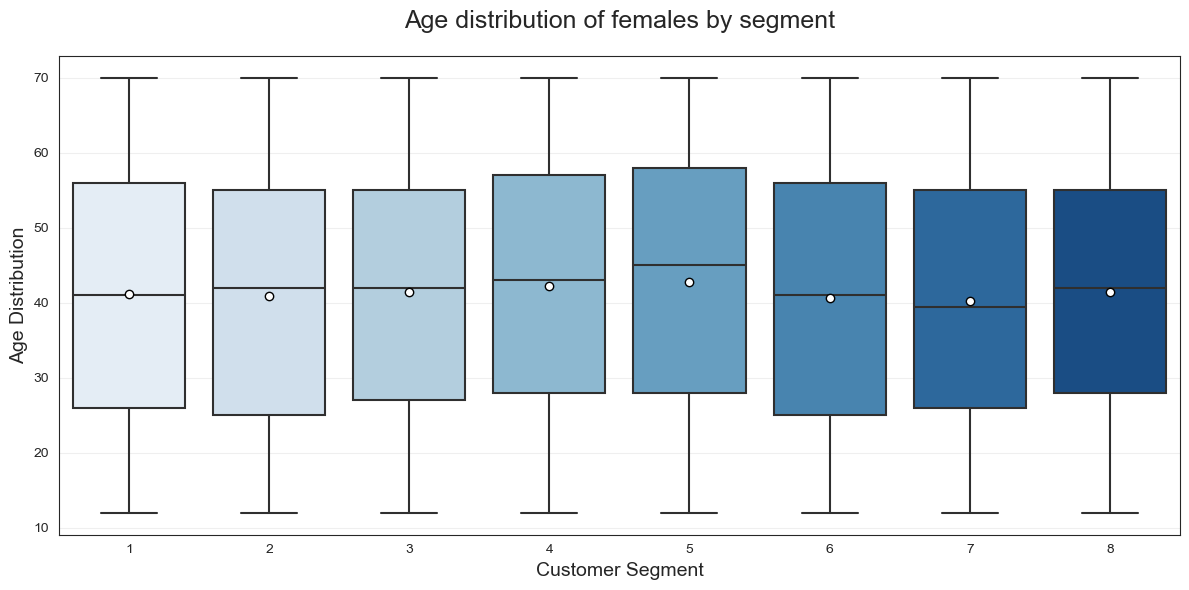

In [95]:
cust_segment_age_boxplot(Demographic_segment_female, 'Age distribution of females by segment')

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">

### 🔍 Female Customer Segments — Summary & Insights
<br>

| Segment | Top 2 Categories                                | Avg Age | Top Region | Customer Count |
|---------|------------------------------------------------|---------|-------------|----------------|
| 1       | Intimates, Dresses                             | 41.1    | South       | 595            |
| 2       | Accessories, Swim                              | 41.0    | South       | 465            |
| 3       | Jeans, Intimates                               | 41.5    | South       | 298            |
| 4       | Socks & Hosiery, Outerwear & Coats             | 42.2    | South       | 818            |
| 5       | Tops & Tees, Intimates                         | 42.8    | South       | 303            |
| 6       | Active, Plus                                   | 40.7    | South       | 1088           |
| 7       | Maternity, Dresses                             | 40.2    | South       | 818            |
| 8       | Sleep & Lounge, Fashion Hoodies & Sweatshirts  | 41.4    | South       | 586            |

---

### 📌 Key Observations

- **Regional Homogeneity**  
  All segments are concentrated in the *Southern* region, indicating a strong regional dominance in female customer engagement or possibly a data bias toward the South.

- **Age Similarity**  
  The average age across segments ranges from **40.2 to 42.8 years**, suggesting the majority of female customers are within a **narrow middle-age band**, potentially reflecting stable lifestyle needs.

- **Category Focus Patterns**
  - **Segment 1 & 3**: Strong preference for **Intimates**, with Segment 3 also leaning toward **Jeans**.
  - **Segment 2**: Indicates seasonal or leisure interest via **Accessories** and **Swimwear**.
  - **Segment 4**: Reflects practical needs via **Socks & Hosiery** and **Outerwear**.
  - **Segment 5**: Focused on **basic versatile items** like Tops & Tees and Intimates.
  - **Segment 6**: Leans toward **Activewear** and **Plus size**, suggesting body-inclusive, active lifestyle preferences.
  - **Segment 7**: Shows a clear demand for **Maternity** and **Dresses**, implying possible family-oriented needs.
  - **Segment 8**: Comfort-focused, favoring **homewear and casual styles**.

- **Segment Size Distribution**
  - Segment **6** is the largest (1,088 customers), suggesting **activewear and plus-size** clothing has broad appeal.
  - Segments **3** and **5** are the smallest, possibly indicating more niche interests.

---

### 🎯 Strategic Implications

- **Personalization**: These segments provide a strong foundation for **personalized product recommendations** based on dominant interests.
- **Campaign Design**: Marketing campaigns can be **age- and region-aligned** with emphasis on top categories.
- **Product Positioning**: Clear focus areas (e.g., Intimates, Activewear, Maternity) allow for **targeted inventory planning**.


<a id="Concl"></a>
# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Georgia;text-align:center;display:fill;border-radius:30px;background-color:#404040;overflow:hidden"><b>Conclusions & Insights</b></div>

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">

# 📊 Executive Summary of Findings & Insights

## 🧩 1. Overview of the Dataset

- **13,756 products** across **26 original categories**.
- High **dimensionality** and **sparsity** in raw data (>90% zeros in customer × product matrix).
- To address this:
  - Merged small or similar categories to reduce noise.
  - Focused on three matrix views:
    - Full Matrix (Customer × Merged Categories)
    - Male Matrix (Customer × Original Categories – Males only)
    - Female Matrix (Customer × Original Categories – Females only)

---

## 📦 2. Category Statistics Summary

| Dataset             | Mean Range   | Std Dev Range | Observations               |
|---------------------|--------------|----------------|----------------------------|
| **Merged Categories** | 0.01 – 1.23  | 0.3 – 2.4       | Sparse; long-tailed        |
| **Male Only**         | 0.2 – 0.65   | 0.7 – 1.8       | Sparse; high variance       |
| **Female Only**       | 0.01 – 1.01  | 0.3 – 2.1       | Sparse; niche interests     |

✅ `RobustScaler(with_centering=False)` was used to preserve zeroes and handle long-tailed distributions.

---

## 🔍 3. Segmentation Using NMF

### 📌 Merged Categories (5 Components)

| Segment | Top Categories                        | Profile Description                         |
|--------:|---------------------------------------|---------------------------------------------|
| 1       | Bottoms, Underwear, Outerwear         | Practical and daily essentials              |
| 2       | Maternity, One-Pieces, Plus           | Maternity & plus-size comfort shoppers      |
| 3       | Hoodies, Socks & Hosiery              | Cozy, casual homewear-oriented              |
| 4       | Sleep & Lounge, Accessories           | Gift/minimal apparel focus                  |
| 5       | Swim, Sweaters                        | Seasonally influenced buyers                |

### 📌 Male Customers (6 Components)

| Segment | Top Categories                         | Profile Description                         |
|--------:|----------------------------------------|---------------------------------------------|
| 1       | Accessories, Active                    | Sporty, accessory-focused                   |
| 2       | Socks, Suits, Underwear                | Basics + occasional formals                 |
| 3       | Jeans, Shorts                          | Casual dressers                             |
| 4       | Pants, Sweaters, Swim                  | Practical + seasonal wardrobe               |
| 5       | Tops & Tees, Hoodies                   | Trend-driven/streetwear                     |
| 6       | Underwear, Sleep & Lounge              | Comfort-first, homewear lovers              |

### 📌 Female Customers (8 Components)

| Segment | Top Categories                                | Profile Description                         |
|--------:|-----------------------------------------------|---------------------------------------------|
| 1       | Intimates                                      | Intimate apparel enthusiasts                |
| 2       | Accessories, Swim                              | Seasonal, leisure-oriented                  |
| 3       | Jeans, Intimates                               | Casual core wear                            |
| 4       | Outerwear, Pants, Hosiery                      | Practical wear lovers                       |
| 5       | Tops & Tees, Intimates                         | Daily basics                                |
| 6       | Active, Plus                                   | Body-inclusive activewear                   |
| 7       | Dresses, Maternity, Skirts                     | Feminine or maternity needs                 |
| 8       | Hoodies, Sleep & Lounge                        | Home comfort & casual fashion               |

---

## 👥 Demographic & Geographic Summary

| Matrix         | Age Range | Region Dominance | Gender Split                  |
|----------------|-----------|------------------|-------------------------------|
| Merged         | ~41       | South            | Segment 2 = 100% Female       |
| Male-Only      | 38–42     | South            | All segments = Male           |
| Female-Only    | 40–43     | South            | All segments = Female         |

> ✅ The South region dominates across all datasets.  
> ✅ Most customers fall into the **middle-age band** (38–43 years).  
> ✅ Strong homogeneity supports broad targeting with segment-specific product focus.

---

## ✅ Modeling Strategy Recommendations

- **NMF outperforms K-Means and SVD** in this sparse retail context due to:
  - Non-negativity
  - Interpretability
  - Zero-preserving nature

- **Preprocessing is essential**:
  - Use `RobustScaler(with_centering=False)` for sparse gender-specific matrices.
  - Use `StandardScaler(with_mean=False)` for merged matrices to preserve NMF compatibility.

- **Segmentation is actionable**:
  - Each segment has distinct behavioral profiles.
  - Supports email targeting, bundling, site personalization, and inventory planning.

---

## 🎯 Final Takeaways

- ✅ Data sparsity is a challenge—but also an opportunity when paired with the right method (NMF).
- ✅ Merged categories simplify modeling but retain valuable behavioral variance.
- ✅ Gender-segmented matrices reveal more precise patterns and enable tailored marketing.
- ✅ Demographic profiles (age/region) reinforce consistency and enable scalable strategies.

> By combining category-level normalization, dimensionality reduction via NMF, and strategic segmentation by gender, we uncover actionable and interpretable customer patterns—ready for use in marketing, recommendation engines, and product planning.


<br>

<a id="Tableau"></a>
# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Georgia;text-align:center;display:fill;border-radius:30px;background-color:#404040;overflow:hidden"><b>View On Tableau</b></div>

<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f5f5f5; 
    border-radius: 10px;
">
    
### View the project's visualization summary on Tableau:

https://public.tableau.com/app/profile/mohammed.elshennawy/viz/DrapeAura2023E-CommerceAnalysisProductSegmentation/Story